
# EDA DataSet ARQDIGITAL - People Analytics: Diagnóstico Preditivo de Turnover

**Visão Executiva da Análise**
Este documento apresenta a Análise Exploratória de Dados (EDA) que fundamenta a construção do nosso **Modelo Preditivo de Pedidos de Demissão (Turnover Voluntário)**

O objetivo dessa análise é realizar uma busca aprofundada e completa na qualidade dos dados da nossa *One Big Table* (OBT) e descobrir quais os verdadeiros motivos que estão influenciando a reteção. Para isso, cruzamos quatro pontos estratégicos da nossa operação:

* **Fator Humano & Demográfico:** Idade, Gênero, Estado Cívil e Estrutura Familia (Dependentes).
* **Fator Organizacional:** Tempo de Casa, Nível Hierárquico, Tipo de Contaro e Departamento.
* **Fator Financeiro:** Salário Contratual, Valor Líquido e Pacote de Benefícios Corporativos.
* **Fator Cultural:** Mapeamento de Perfil Comportamental (Sólides Profiler).

**Regra de Negócio (Target)**

Nossa variável alvo (`target_pediu_demissao`) foi desenhada com uma trava de isolamento preciso no proprío DW Consolidado de RH. O alvo foca *exclusivamente* nas demissões voluntárias (1), contra a nossa base de talentos ativos (0). Demissões involuntárias foram retiradas para não contaminar o padrão do comportalmente de pedidos de demissão.

## Perguntas Inicias sobre o Nosso Dataframe

1. **O Volume (linhas e colunas).**

    - **Resposta**: 91 Linhas e 22 Colunas

2. Onde estão os Buracos (nulos).

    - **Resposta**: Nas colunas
    |Coluna| Quantidade|
    |-------|----------|
    |data_demissao| 64|
    |perfil_comportamental| 7|
    |salario_contratual| 4|
    |turno_trabalho| 4|
    |valor_liquido| 4|
    |cidade| 2|
    |estado| 2|
    |estado_civil| 1|
    |tipo_contrato| 1|
    |nivel_hierarquico| 1|


3. A nossa Proporção exata de quem saiu vs. quem ficou.

    - **Resposta**
| Target      | Proporçao |
|-------------|-----------|
| 0| 69.230769 |
| 1| 30.769231 |



In [1]:
# Marco 0 - Importando as libs de analise e visualização inicais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import requests
from numpy.ma.extras import column_stack
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression


In [2]:
# Marco 1 EDA - Lendo o Dataset
path = '/content/base (1).csv'
df = pd.read_csv(path, sep = ',')
df

,colaborador_sk,data_nascimento,genero,estado_civil,escolaridade,cep,bairro,cidade,estado,data_admissao,...,departamento_nome_api,cargo_nome_api,turno_trabalho,tipo_contrato,total_beneficios_api,target_pediu_demissao,qtd_dependentes,perfil_comportamental,salario_contratual,valor_liquido
0,96,2004-09-18,Feminino,Solteiro,Superior (cursando),72220096,Ceilândia,Brasília,DF,2023-02-13,...,OPERACIONAL,ANALISTA OPERACIONAL I,Comercial,CLT,2225.52,0,0,PA,2491.0,1044.08
1,131,1982-09-17,Feminino,Casado,Pós Graduação,71907000,Norte (Águas Claras),Brasília,DF,2023-12-04,...,COMUNICAÇÃO,Analista de Comunicação e Marketing III,Comercial,CLT,0.00,1,2,PEC,6000.0,0.00
2,125,1979-11-06,Masculino,Divorciado,Superior Completo,70277060,Asa Sul,Brasília,DF,2025-09-22,...,NOVOS NEGÓCIOS,GERENTE DE NEGÓCIOS,Comercial,CLT,2829.92,0,1,E,15000.0,10699.10
3,106,1981-04-06,Feminino,Casado,Pós Graduação,73105903,SOBRADINHO,Brasília,DF,2021-03-08,...,OPERACIONAL,ASSISTENTE DE OPERAÇÕES,Comercial,CLT,0.00,1,0,NaN,3203.0,0.00
4,16,1987-06-12,Masculino,Casado,Pós Graduação,71882165,Riacho Fundo II,Brasília,DF,2024-01-15,...,ADMINISTRATIVO / FINANCEIRO,LÍDER ADMINISTRATIVO E FINANCEIRO,Comercial,CLT,2619.76,0,3,EA,7661.0,5880.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,33,1988-07-20,Feminino,Solteiro,Superior Completo,71573201,Paranoá,Brasília,DF,2024-02-05,...,OPERACIONAL,ANALISTA OPERACIONAL I,Comercial,Contrato,2642.56,0,0,PA,2500.0,2240.73
87,39,1996-11-08,Feminino,Solteiro,Superior (cursando),66050140,Umarizal,Belém,PA,2023-01-09,...,OPERACIONAL,ASSISTENTE OPERACIONAL,Comercial,CLT,2362.77,0,0,CE,7098.0,4775.54
88,90,1999-05-22,Feminino,Solteiro,Pós Graduação (cursando),73105903,Grande Colorado (Sobradinho),Brasília,DF,2025-02-19,...,JURÍDICO,ASSISTENTE JURIDICO,Comercial,CLT,2407.14,0,4,EAP,2322.0,1996.11
89,51,1992-07-07,Feminino,Solteiro,Superior Completo,71071012,Guará II,Brasília,DF,2024-09-02,...,CONTRATA,ANALISTA ADMINISTRATIVO (DIRETORIA),Comercial,CLT,2535.78,0,2,PCA,3166.0,282.42


In [3]:
# Marco 1.1 EDA - Entendo o dataset e suas caracteristicas
linhas, colunas = df.shape
print(f'O dataset tem um total de {linhas} linhas e {colunas} colunas')

O dataset tem um total de 91 linhas e 22 colunas


In [4]:
# Marco 1.2 EDA - Vendo a quantidade de Valores NUlos
df.isna().sum(axis = 0).sort_values(ascending = False)

,0
data_demissao,64
perfil_comportamental,7
valor_liquido,5
salario_contratual,5
turno_trabalho,4
cidade,2
estado,2
estado_civil,1
tipo_contrato,1
nivel_hierarquico,1


In [5]:
# Marco 1.3 EDA - Proporção de pedidos de demissão
proporcao_df = df[['target_pediu_demissao']].value_counts(
    normalize=True
).rename(
    index = {1: 'Desligamentos Voluntairos', 0: 'Ativos'}
).to_frame(name = 'Proporção')

proporcao_df['Proporção'] = proporcao_df['Proporção'].map('{:.2%}'.format)
proporcao_df

,Proporção
target_pediu_demissao,
Ativos,69.23%
Desligamentos Voluntairos,30.77%


In [6]:
# Marco 1.4 EDA - Verificando a coluna que possui salarios como NULL
df[df['salario_contratual'].isna()]

# Criando uma copia do dataset por segurança
df_clean = df.copy()

df_clean.loc[df_clean['colaborador_sk'] == 237, 'salario_contratual'] = 7200
df_clean.loc[df_clean['colaborador_sk'] == 260, 'salario_contratual'] = 10054.14
df_clean.loc[df_clean['colaborador_sk'] == 179, 'salario_contratual'] = 900

# De 4 salarios null reduzimos para 1
df_clean[df_clean['salario_contratual'].isna()]

,colaborador_sk,data_nascimento,genero,estado_civil,escolaridade,cep,bairro,cidade,estado,data_admissao,...,departamento_nome_api,cargo_nome_api,turno_trabalho,tipo_contrato,total_beneficios_api,target_pediu_demissao,qtd_dependentes,perfil_comportamental,salario_contratual,valor_liquido
31,94,2000-04-14,Feminino,Casado,Pós Graduação,71070515,Guará II,Brasília,DF,2026-01-29,...,ADMINISTRATIVO / FINANCEIRO,ANALISTA FINANCEIRO I,Integral,CLT,2384.34,0,0,CP,NaN,NaN
75,200,1996-12-22,Masculino,NaN,Superior Completo,71572810,PARANOA,Brasília,DF,2021-03-15,...,ADMINISTRATIVO / FINANCEIRO,ANALISTA ADMINISTRATIVO,NaN,CLT,0.00,1,0,bloqueado,NaN,NaN


In [7]:
# Dropando o salario NULL
df_clean.dropna(
    subset = ['salario_contratual'],
    inplace = True
)

# Confirmando que não tem mais salarios nulls na base
df_clean[df_clean['salario_contratual'].isna()]

,colaborador_sk,data_nascimento,genero,estado_civil,escolaridade,cep,bairro,cidade,estado,data_admissao,...,departamento_nome_api,cargo_nome_api,turno_trabalho,tipo_contrato,total_beneficios_api,target_pediu_demissao,qtd_dependentes,perfil_comportamental,salario_contratual,valor_liquido


In [8]:
# Preenchendo as colunas que apresentam valores NaN que não forma informados.
df_clean.fillna({
    'cidade': 'Não Informado',
    'estado': 'Estado Informado',
    'estado_civil': 'Não Informado',
    'nivel_hierarquico': 'Não Informado',
    'turno_trabalho': 'Não Informado',
    'tipo_contrato': 'Não Informado',
    'perfil_comportamental': 'Não Mapeado.'
}, inplace = True
)

df_clean.isna().sum(axis = 0).sort_values(ascending = False)

,0
data_demissao,63
valor_liquido,3
genero,0
estado_civil,0
colaborador_sk,0
data_nascimento,0
cep,0
escolaridade,0
estado,0
bairro,0


In [9]:
# Conferindo os tipos de dados presentes no dataset
df_clean[['data_admissao', 'data_demissao', 'data_nascimento']].info() # -> Todas as colunas de data estão com o formato STR

# Criando uma função para limpar as datas
def limpar_datas(dataset = 'Dataframe alvo', colunas = 'Colunas do Dataframe'):
    """
    Converte uma lista de colunas para o tipo datetime

    :parameter dataset: dataframe alvo
    :parameter colunas: lista com o nome das colunas dentro do dataset alvo no formato de string

    :return: Dataframe limpe com as colunas com tipos corretos.
    """

    # Loop explicito com a limpeza
    for col in colunas:
        dataset[col] = pd.to_datetime(dataset[col], format = '%Y-%m-%d', dayfirst = True)

    return dataset

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 0 to 90
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   data_admissao    89 non-null     object
 1   data_demissao    26 non-null     object
 2   data_nascimento  89 non-null     object
dtypes: object(3)
memory usage: 2.8+ KB


In [10]:
# Data limpas e conferidas
colunas_data = df_clean[['data_admissao', 'data_demissao', 'data_nascimento']]
df_clean = limpar_datas(df_clean, colunas_data)

df_clean[['data_admissao', 'data_demissao', 'data_nascimento']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 0 to 90
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data_admissao    89 non-null     datetime64[ns]
 1   data_demissao    26 non-null     datetime64[ns]
 2   data_nascimento  89 non-null     datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 2.8 KB


In [11]:
# Criação de 3 colunas novas para descobrirmos tempo de casa e idade
df_clean['data_corte'] = np.where(
    df_clean['data_demissao'].notnull(),
    df_clean['data_demissao'], date.today()
)

df_clean['data_corte'] = pd.to_datetime(df_clean['data_corte'], format = 'mixed', dayfirst = True)

# Criação da coluna de idade e tempo de casa em meses
df_clean['idade'] = ((df_clean['data_corte'] - df_clean['data_nascimento']).dt.days // 365).astype(int)
df_clean['meses_de_casa'] = ((df_clean['data_corte'] - df_clean['data_admissao']).dt.days / 30).astype(float).round(2)

df_clean[['idade', 'meses_de_casa']]

,idade,meses_de_casa
0,21,36.90
1,41,5.73
2,46,5.17
3,41,17.87
4,38,25.70
...,...,...
86,37,25.00
87,29,38.07
88,26,12.33
89,33,18.00


In [12]:
# Consultando as idades e o tempo de casa
df_clean[['idade', 'meses_de_casa']].describe()
filtro_idade = df_clean['idade'] <= 0
filtro_tempo_casa = df_clean['meses_de_casa'] <= 0
filtro_aninhado = filtro_idade | filtro_tempo_casa

df_clean_filtrado = df_clean[filtro_aninhado]
df_clean_filtrado[['colaborador_sk', 'data_admissao', 'data_demissao', 'data_nascimento', 'idade', 'meses_de_casa']]

,colaborador_sk,data_admissao,data_demissao,data_nascimento,idade,meses_de_casa


In [13]:
# Consultando as colunas total beneficios e valor líquido
df_clean_filtrado_turnover = df_clean[df_clean['target_pediu_demissao'] == 1]
df_clean_filtrado_turnover[['total_beneficios_api', 'valor_liquido']].agg(['mean', 'min', 'max', 'std', 'median']).T

# Dropando as colunas que não terão mais usop
df_clean_filtrado_turnover.drop(
    columns = ['total_beneficios_api', 'valor_liquido', 'data_nascimento', 'data_admissao', 'data_corte', 'colaborador_sk', 'data_demissao', 'tipo_contrato', 'turno_trabalho'],
    inplace = True
)

/tmp/ipython-input-1388494552.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtrado_turnover.drop(


In [14]:
df_clean_filtrado_turnover

,genero,estado_civil,escolaridade,cep,bairro,cidade,estado,nivel_hierarquico,departamento_nome_api,cargo_nome_api,target_pediu_demissao,qtd_dependentes,perfil_comportamental,salario_contratual,idade,meses_de_casa
1,Feminino,Casado,Pós Graduação,71907000,Norte (Águas Claras),Brasília,DF,Médio,COMUNICAÇÃO,Analista de Comunicação e Marketing III,1,2,PEC,6000.00,41,5.73
3,Feminino,Casado,Pós Graduação,73105903,SOBRADINHO,Brasília,DF,Alto,OPERACIONAL,ASSISTENTE DE OPERAÇÕES,1,0,Não Mapeado.,3203.00,41,17.87
5,Masculino,Solteiro,Médio Completo,72583250,Setor Meireles (Santa Maria),Brasília,DF,Baixo,OPERACIONAL,ASSISTENTE DE OPERAÇÕES,1,0,EA,1964.83,19,3.00
7,Feminino,Casado,MBA,72236211,Ceilândia Sul (Ceilândia),Brasília,DF,Alto,ADMINISTRATIVO / FINANCEIRO,GERENTE ADMINISTRATIVO FINANCEIRO,1,3,PA,3430.00,35,134.00
9,Masculino,Casado,Superior Completo,73045151,Sobradinho,Brasília,DF,Médio,RELACIONAMENTO,ANALISTA DE BI II,1,3,A,15748.00,39,6.87
19,Masculino,Solteiro,Superior Completo,71725701,CANDANGOLANDI,Brasília,DF,Médio,TI,ANALISTA DE TECNOLOGIA,1,0,PC,5948.80,35,19.17
23,Masculino,Casado,Superior Completo,71907180,AGUAS CLARAS,Brasília,DF,Médio,TI,ANALISTA DE TECNOLOGIA,1,0,Não Mapeado.,7200.00,38,0.97
32,Feminino,Solteiro,Superior Completo,71010204,GUARA,Brasília,DF,Alto,ADMINISTRATIVO / FINANCEIRO,LÍDER,1,0,E,2413.00,35,24.93
35,Feminino,Casado,Superior Completo,66095050,Marco,Não Informado,Estado Informado,Médio,RELACIONAMENTO,ESPECIALISTA EM EXPERIÊNCIA DO CLIENTE,1,0,CE,5000.00,40,2.83
41,Masculino,Casado,Pós Graduação,72876027,Etapa A,Valparaíso de Goiás,GO,Médio,ADMINISTRATIVO / FINANCEIRO,ANALISTA DE BI,1,0,PA,7000.00,26,2.57


# EDA FASE 1

Com a limpeza feita e os tipos tratados, podemos iniciar nossa análise. Podemos então tentar a pergunta mais clara **"Quando"** as
pessoas estão decidindo sair da empresa? Por que se descobrirmos que a maioria está saindo no 6° mês de empresa, podemos definir
que temos um problema no onbording, mas se estão saindo depois de 12, 24, 36 meses é simplesmente estagnação e falta de plano de
carreira.
> Com a visualização, identificamos uma alta concentração de saídas na janela inicial de 0 a 10 meses, formando uma distribuição fortemente assimétrica à direita _(Positive Skew)_. Notamos que a presença de casos atípicos (outliers) de colaboradores antiquíssimos pedindo desligamento distorceu a nossa média matemática para cima. Portanto, a Mediana torna-se a nossa métrica de ouro para representar a realidade da empresa.

**Média de Sobrevida = 11.94 Meses**

**Mediana de Sobrevida = 9.23 Meses**

> **Insight Principal:** O nosso principal ponto de quebra (Mediana) ocorre no **"Fim da Lua de Mel"** (pouco depois do 9° mês). Isso indica que o problema não é apenas no onbording inicial. O colaborador sobrevive ao período de experiência legal (90 dias), mas entra em atrito com a liderança, cultura ou rotina operacional logo nos primeiros meses como efetivo definitivo. Percebendo que possa existir uma estagnação, ou até cobranças ilogicas.

In [15]:
# Já criamos um dataset temporario chamado "df_clean_filtrado_turnover"
# Verificando as estatisticas dele.
#df_clean_filtrado_turnover[df_clean_filtrado_turnover['meses_de_casa'] == 134]
limite_superior = df_clean_filtrado_turnover['meses_de_casa'].quantile(0.95)
print(limite_superior)


# Realiznado a winsorização
df_clean_filtrado_turnover['meses_de_casa'] = df_clean_filtrado_turnover['meses_de_casa'].clip(
    upper = limite_superior
)

40.06099999999999


/tmp/ipython-input-4142744265.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtrado_turnover['meses_de_casa'] = df_clean_filtrado_turnover['meses_de_casa'].clip(


In [16]:
df_clean_filtrado_turnover['meses_de_casa'].describe()

,meses_de_casa
count,27.000000
mean,11.964148
std,11.255111
min,0.170000
25%,3.730000
50%,9.230000
75%,15.735000
max,40.061000


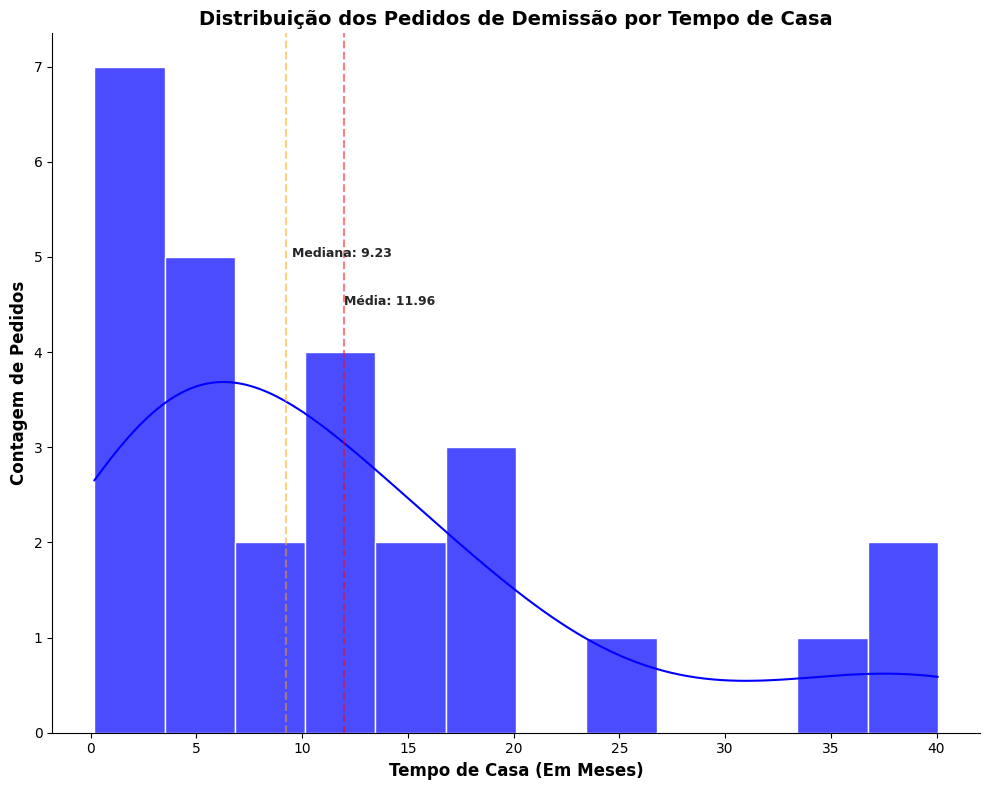

In [17]:
#@ Title Código completo Histograma com KDE
fig, ax = plt.subplots(figsize = (10, 8))
sns.set_style('white')
sns.histplot(
    data = df_clean_filtrado_turnover,
    x = 'meses_de_casa',
    color = 'blue',
    alpha = 0.7,
    kde = True,
    ax = ax,
    bins = 12
)

plt.ylabel('Contagem de Pedidos', fontweight = 'bold', fontsize = 12)
plt.xlabel('Tempo de Casa (Em Meses)', fontweight = 'bold', fontsize = 12)

plt.title(
    'Distribuição dos Pedidos de Demissão por Tempo de Casa',
    fontsize = 14,
    fontweight = 'bold'
)
plt.axvline(
    x = df_clean_filtrado_turnover['meses_de_casa'].mean(),
    ls = '--',
    color = 'red',
    alpha = 0.5
)
ax.annotate(
    f'Média: {df_clean_filtrado_turnover['meses_de_casa'].mean():.2f}',
    xy = (6, 6),
    xytext = (12, 4.5),
    fontweight = 'bold',
    fontsize = 9
)

plt.axvline(
    x = df_clean_filtrado_turnover['meses_de_casa'].median(),
    ls = '--',
    color = 'orange',
    alpha = 0.5
)

ax.annotate(
    f'Mediana: {df_clean_filtrado_turnover['meses_de_casa'].median():.2f}',
    xy = (6, 6),
    xytext = (9.5, 5),
    fontweight = 'bold',
    fontsize = 9
)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig(
    'distribuicao_tempo.png',
    dpi = 900
)
plt.show()

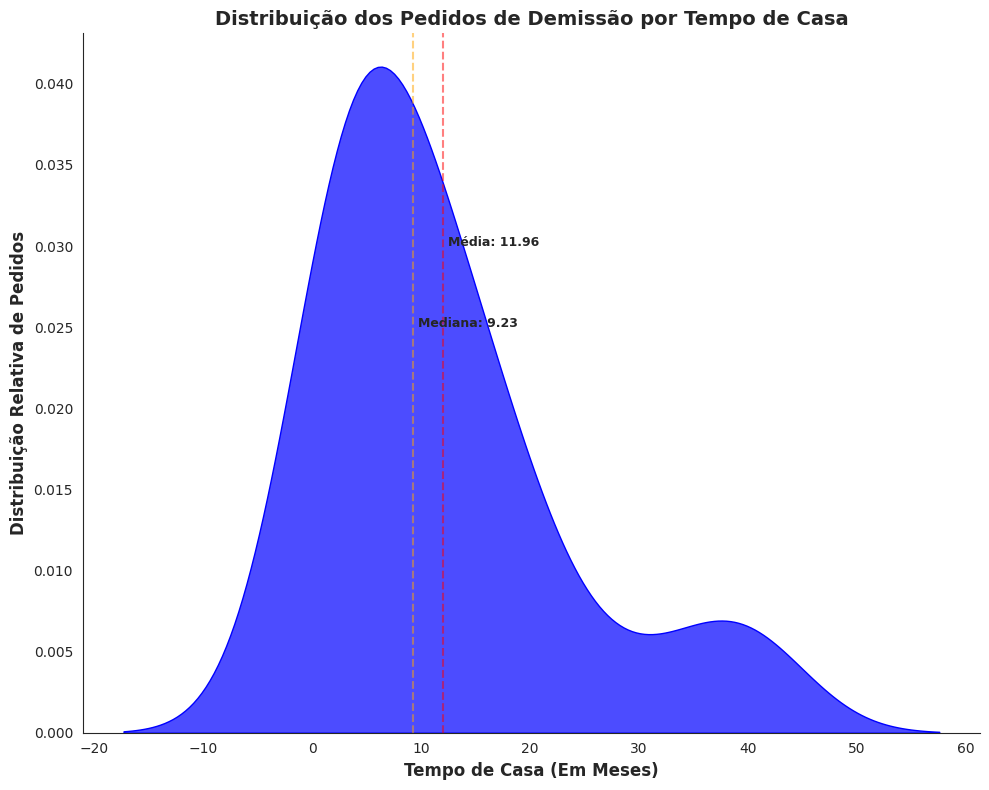

In [18]:
#@ Title Código completo Histograma com KDE
fig, ax = plt.subplots(figsize = (10, 8))
sns.set_style('white')
sns.kdeplot(
    data = df_clean_filtrado_turnover,
    x = 'meses_de_casa',
    color = 'blue',
    alpha = 0.7,
    ax = ax,
    fill = True
)

plt.ylabel('Distribuição Relativa de Pedidos', fontweight = 'bold', fontsize = 12)
plt.xlabel('Tempo de Casa (Em Meses)', fontweight = 'bold', fontsize = 12)

plt.title(
    'Distribuição dos Pedidos de Demissão por Tempo de Casa',
    fontsize = 14,
    fontweight = 'bold'
)
plt.axvline(
    x = df_clean_filtrado_turnover['meses_de_casa'].mean(),
    ls = '--',
    color = 'red',
    alpha = 0.5
)
ax.annotate(
    f'Média: {df_clean_filtrado_turnover['meses_de_casa'].mean():.2f}',
    xy = (12.5, 0.030),
    xytext = (12.5, 0.030),
    fontweight = 'bold',
    fontsize = 9
)

plt.axvline(
    x = df_clean_filtrado_turnover['meses_de_casa'].median(),
    ls = '--',
    color = 'orange',
    alpha = 0.5
)

ax.annotate(
    f'Mediana: {df_clean_filtrado_turnover['meses_de_casa'].median():.2f}',
    xy = (9.75, 0.025),
    xytext = (9.75, 0.025),
    fontweight = 'bold',
    fontsize = 9
)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig(
    'distribuicao_tempo.png',
    dpi = 900
)
plt.show()

In [19]:
df_clean_filtrado_turnover['meses_de_casa'].agg(['min', 'max', 'mean', 'median'])

,meses_de_casa
min,0.170000
max,40.061000
mean,11.964148
median,9.230000


# **Quem está saindo?**

Já conseguimos identificar que temos um early tunover alto, com uma mediana de ~9 meses. Mas precisamos ir mais afundo e descobrir
o perfil de quem está saindo, vamos identificar agora se as pessoas com um perfil comportamente X está saíndo mais que Y e se o
nível hierarquico tem algum impacto.

**O Risco Hierárquico**
- **Nível Baixo:** É a zona de hemorragia crítica. A caixa de distribuição está espremida no limite inferior, com uma mediana de turnover cravada em **~3 meses**, raramente ultrapassando os 8 meses. Nossa base operacional está saindo muito antes de se pagarem.
- **Nível Médio e Alto:** Apresentam uma resiliência significativamente maior. O nível médio possui uma mediana de ~9 meses, enquanto a alta liderança chega a ~21 meses, demonstrando uma sobrevida absurda em comparação ao restante da empresa.

**O Risco Comportamental**
Ao olhar a metodologia Sólides, notamos que os perfis EA, PEC e AEP, juntamente com uma grande concentração de PA e E, formam o nosso grupo de risco inicial
- **AEP, EA e PEC (Zona de Risco):** Formam a base do risco imediato. O perfil AEP possui uma evasão quase instantânea, enquanto EA e PEC possuem caixas minúsculas com medianas entre 3 e 5 meses.
- **CE e PC (Risco moderado):** Possuem medianas próximas à média global da empresa (em torno de 9 a 10 meses), indicando que passam pelo onbording, mas tendem a sair pouco tempo depois.
- **PA (Alta Resiliência):** Ao contrário dos perfis executores puros, o Planejados Analista (PA) demonstra altíssima sobrevida na nossa operação, ostentando uma mediana de **~15 meses**, com uma caixa alongada indicando retenção de longo prazo.

> **Insight Principal** O nosso **_"early turnover"_** tem um perfil comportamental claro. Estamos perdendo talentos dos perfis **AEP, EA, PEC e E** de forma muito prematura. Em contrapartida, perfis mais analíticos ou de planejamento (como o PA) demonstram um fit cultural muito maior com a estabilidade de longo pazeo da nossa operação.

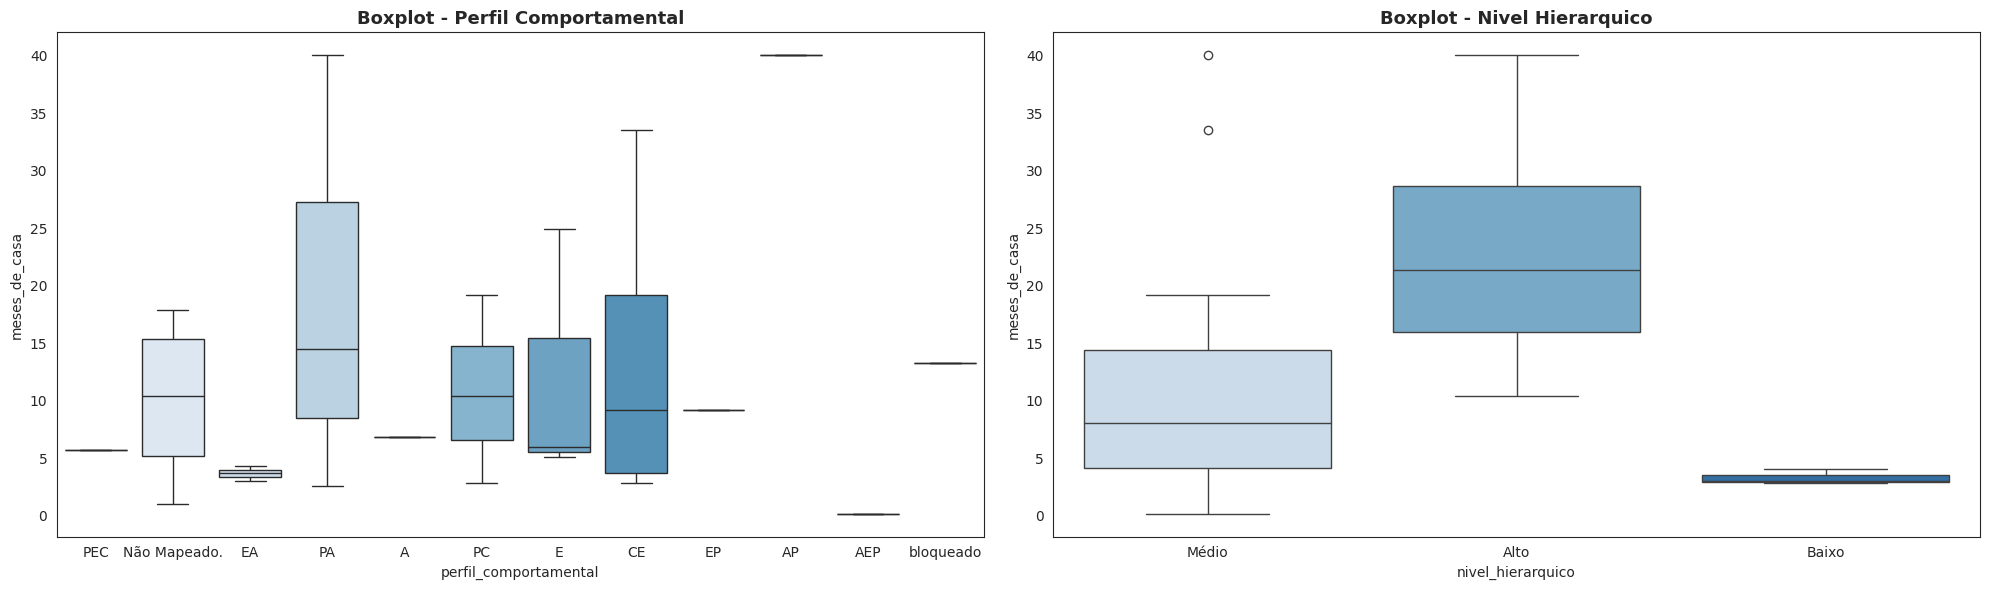

In [20]:
# Plotando um boxplot por perfil comportamental e nível hierarquico
fig, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.boxplot(
    data = df_clean_filtrado_turnover,
    ax = ax[0],
    x = 'perfil_comportamental',
    hue = 'perfil_comportamental',
    y = 'meses_de_casa',
    palette = 'Blues'
)


sns.boxplot(
    data = df_clean_filtrado_turnover,
    ax = ax[1],
    x = 'nivel_hierarquico',
    hue = 'nivel_hierarquico',
    y = 'meses_de_casa',
    palette = 'Blues'
)

ax[0].set_title(
    'Boxplot - Perfil Comportamental',
    fontweight = 'bold',
    fontsize = 13
)

ax[1].set_title(
    'Boxplot - Nivel Hierarquico',
    fontweight = 'bold',
    fontsize = 13
)

plt.tight_layout()
plt.show()


# De onde estão saindo?

Finalizando a Análise Exploratória, cruzamos os eventos de desligamento com a estrutura de Departamentos que possuímos hoje.

> Nota Técnica: Para evitar distorções de escala (áreas grandes naturalmente demitem mais em números absolutos), isolamos a **taxa de turnover proporcionalmente (%).** Essa métrica revela a verdadeira capacidade de retenção de cada setor.

O mapa de calor expôs que nossa crise de turnover não é uma epidemia cultural generalizada, na verdade ela é um problema isolado em áreas de gestão e estresse operacional:

**Diagnóstico Setorial:**

- **Relacionamento (Alerta Maximo)**: É o epicentro absoluto da nossa perda de capital. O setor registra uma taxa de turnover extremamente alta de 62.50%. Com um olhar matematico, a cada 10 colaboradores que são contratados para essa área, **mais de 6 não suportam a rotina e pedem para sair em torno de ~9 meses**.
- **Tecnologia da Informação TI (Fuga de Especialistas):** Está no segundo lugar nos índices de turnover com 38.10% de evasão. Um número altamente preocupante, tendo em vista que o custo de reposição e a curva de aprendizado de profissionais de TI são os mais caros da empresa.
- **Áreas Administrativas (Administrativo e Financeiro):** O setor Administrativo/Finaceiro **(33.33%)** e Operacional **(29.17%)** apresentam taxas que preocupam, e que devemos acompanhar para não aumentar. Mas não são os principais causadores das percas de talentos atual.

> **Análise Final:** O nosso problema de retenção possui uma assinatura delineada e perfeitamente desenhada. O **early turnover** da empresa:

In [21]:
df_clean


,colaborador_sk,data_nascimento,genero,estado_civil,escolaridade,cep,bairro,cidade,estado,data_admissao,...,tipo_contrato,total_beneficios_api,target_pediu_demissao,qtd_dependentes,perfil_comportamental,salario_contratual,valor_liquido,data_corte,idade,meses_de_casa
0,96,2004-09-18,Feminino,Solteiro,Superior (cursando),72220096,Ceilândia,Brasília,DF,2023-02-13,...,CLT,2225.52,0,0,PA,2491.0,1044.08,2026-02-24,21,36.90
1,131,1982-09-17,Feminino,Casado,Pós Graduação,71907000,Norte (Águas Claras),Brasília,DF,2023-12-04,...,CLT,0.00,1,2,PEC,6000.0,0.00,2024-05-24,41,5.73
2,125,1979-11-06,Masculino,Divorciado,Superior Completo,70277060,Asa Sul,Brasília,DF,2025-09-22,...,CLT,2829.92,0,1,E,15000.0,10699.10,2026-02-24,46,5.17
3,106,1981-04-06,Feminino,Casado,Pós Graduação,73105903,SOBRADINHO,Brasília,DF,2021-03-08,...,CLT,0.00,1,0,Não Mapeado.,3203.0,0.00,2022-08-26,41,17.87
4,16,1987-06-12,Masculino,Casado,Pós Graduação,71882165,Riacho Fundo II,Brasília,DF,2024-01-15,...,CLT,2619.76,0,3,EA,7661.0,5880.41,2026-02-24,38,25.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,33,1988-07-20,Feminino,Solteiro,Superior Completo,71573201,Paranoá,Brasília,DF,2024-02-05,...,Contrato,2642.56,0,0,PA,2500.0,2240.73,2026-02-24,37,25.00
87,39,1996-11-08,Feminino,Solteiro,Superior (cursando),66050140,Umarizal,Belém,PA,2023-01-09,...,CLT,2362.77,0,0,CE,7098.0,4775.54,2026-02-24,29,38.07
88,90,1999-05-22,Feminino,Solteiro,Pós Graduação (cursando),73105903,Grande Colorado (Sobradinho),Brasília,DF,2025-02-19,...,CLT,2407.14,0,4,EAP,2322.0,1996.11,2026-02-24,26,12.33
89,51,1992-07-07,Feminino,Solteiro,Superior Completo,71071012,Guará II,Brasília,DF,2024-09-02,...,CLT,2535.78,0,2,PCA,3166.0,282.42,2026-02-24,33,18.00


In [22]:
# Criando o agrupamento para pegar o headcount, a taxa de turnover e o salario médio da área.
df_turnover = df_clean.groupby(
    'departamento_nome_api'
).agg(
    Volume_historico = ('colaborador_sk', 'nunique'), # Contando todos os IDs únicos existentes
    Saídas = ('target_pediu_demissao', 'sum'), # Somando os pedidos de demissão
    Salario_Medio = ('salario_contratual', 'mean'),
    Mediana_Salario = ('salario_contratual', 'median')
)

df_turnover['Headcount_Ativo'] = df_turnover['Volume_historico'] - df_turnover['Saídas']

df_turnover['Taxa_Turnover_Real_Pct'] = (df_turnover['Saídas'] / df_turnover['Headcount_Ativo'] * 100).round(2)

df_turnover['Custo_Saidas_Anual'] = df_turnover['Saídas'] * df_turnover['Salario_Medio'] * 6

df_turnover['Custo_Saidas_Anual_Mediana'] = df_turnover['Saídas'] * df_turnover['Mediana_Salario'] * 6

df_turnover = df_turnover[['Headcount_Ativo', 'Saídas', 'Taxa_Turnover_Real_Pct', 'Salario_Medio', 'Custo_Saidas_Anual', 'Mediana_Salario', 'Custo_Saidas_Anual_Mediana']]

df_turnover = df_turnover.sort_values(by='Taxa_Turnover_Real_Pct', ascending=False).round(2)

df_turnover = df_turnover[df_turnover['Saídas']>0]
df_turnover


,Headcount_Ativo,Saídas,Taxa_Turnover_Real_Pct,Salario_Medio,Custo_Saidas_Anual,Mediana_Salario,Custo_Saidas_Anual_Mediana
departamento_nome_api,,,,,,,
RELACIONAMENTO,3,5,166.67,6402.25,192067.50,5000.0,150000.0
TI,13,8,61.54,5203.78,249781.58,4749.0,227952.0
ADMINISTRATIVO / FINANCEIRO,10,5,50.00,4622.17,138665.00,3958.0,118740.0
OPERACIONAL,17,7,41.18,4301.67,180669.98,3008.0,126336.0
COMUNICAÇÃO,3,1,33.33,4616.10,27696.60,5113.2,30679.2
JURÍDICO,4,1,25.00,4795.40,28772.40,3430.0,20580.0


In [23]:
df_relacionamento = df_clean[df_clean['departamento_nome_api'] == 'RELACIONAMENTO']
df_relacionamento['meses_de_casa'].agg(
    Tempo_Medio_Casa = 'mean',
    Mediana_Tempo_Casa = 'median'
)

,meses_de_casa
Tempo_Medio_Casa,14.570
Mediana_Tempo_Casa,8.065


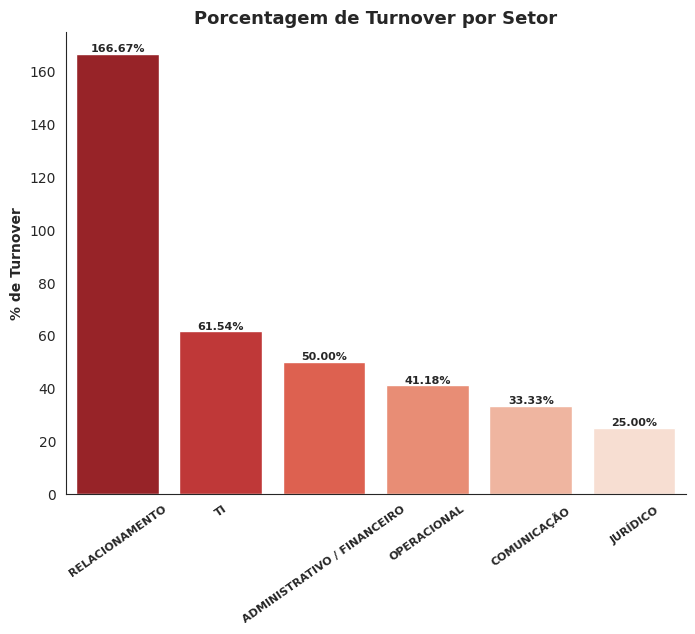

In [24]:
# Criando o plot de barras dos setores que estão sangrando a operação
fig, ax = plt.subplots(figsize = (8, 6))

sns.barplot(
    data = df_turnover,
    x ='departamento_nome_api',
    y = 'Taxa_Turnover_Real_Pct',
    hue = 'departamento_nome_api',
    palette = 'Reds_r'
)

plt.xticks(rotation = 35, fontsize = 8, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('% de Turnover', fontweight = 'bold', fontsize = 10)

for container in ax.containers:
    ax.bar_label(
        container,
        fmt = '%.2f%%',
        label_type = 'edge',
        fontsize = 8,
        fontweight = 'bold'
    )

plt.title(
    'Porcentagem de Turnover por Setor',
    fontsize = 13,
    fontweight = 'bold'
)

ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout
plt.show()

# Modelo Preditivo Fase 2 - Início da modelagem

Com a análise feita descobrimos a **média (9.26)** e a **mediana (11.96)** do tempo de casa que as pessoas tendem a ficar antes de sair, além da proporção de desligamentos que possuimos na base descobrimos que ~30% da base é composta de pedidos de demissão (um cénario estranho, em geral as bases possuem apenas de 7% a 15% de turnover nas bases).
Podemos também visualizar o perfil comportamental e o nível hierarquico  e descobrimos com isso que pessoas com os perfis comportamentais **AEP, EA e PEC** estão na zona de risco inicial, juntamente com pessoas de nível hierarquico baixo.
E tudo isso está concentrado nos setores **Relacionamento, Tecnologia, Administrativo Financeiro e Operacional**, todos com mais de 25% de turnover. Algo preocupante por que vemos que o setor da ponta do négocio está sangrando a operação, e logo após vem a base operacional que determina e cuida do produto e o restante focado nas áreas de suporte como operacional e administrativo/financeiro.

Todas as ações que o time de RH e a diretoria tomar devem ser focadas na gestão da área de relacionamento visto que as pessoas estão saindo após os 6 primeiros meses, então sobrevivem ao onbording mas quando entram na realidade e na rotina do departamento tendem a sair. Focar nos perfis contrados e entender o porque esses perfis tendem a sair mais, além de desenvolver algo para reter os perfis após os 9 meses, como uma estrutura de desenvolvimento desde o momento da entrada.

Com isso definido podemos começar a modelagem preditiva.

In [25]:
# primeiros precisamos excluir todas as colunas sem utilidade
df_clean.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 0 to 90
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   genero                 89 non-null     object
 1   estado_civil           89 non-null     object
 2   escolaridade           89 non-null     object
 3   bairro                 89 non-null     object
 4   cidade                 89 non-null     object
 5   estado                 89 non-null     object
 6   nivel_hierarquico      89 non-null     object
 7   departamento_nome_api  89 non-null     object
 8   cargo_nome_api         89 non-null     object
 9   turno_trabalho         89 non-null     object
 10  tipo_contrato          89 non-null     object
 11  perfil_comportamental  89 non-null     object
dtypes: object(12)
memory usage: 9.0+ KB


In [26]:
# Começando com o one-hot enconding, por que modelos não aceitam textos, 0s e 1s.
# Para isso podemos usar o one-hot enconding automatico do pd.get_dummies com o metodo drop_first
df_clean_pred = df_clean.copy() # -> Copiando o dataset para criar os dummies
df_clean_pred.drop(
    columns = ['colaborador_sk','data_nascimento', 'data_demissao', 'data_admissao', 'tipo_contrato', 'cargo_nome_api', 'total_beneficios_api', 'valor_liquido',
               'data_corte', 'bairro', 'cidade', 'turno_trabalho', 'estado'],
    inplace = True
)

df_clean_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 0 to 90
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   genero                 89 non-null     object 
 1   estado_civil           89 non-null     object 
 2   escolaridade           89 non-null     object 
 3   cep                    89 non-null     int64  
 4   nivel_hierarquico      89 non-null     object 
 5   departamento_nome_api  89 non-null     object 
 6   target_pediu_demissao  89 non-null     int64  
 7   qtd_dependentes        89 non-null     int64  
 8   perfil_comportamental  89 non-null     object 
 9   salario_contratual     89 non-null     float64
 10  idade                  89 non-null     int64  
 11  meses_de_casa          89 non-null     float64
dtypes: float64(2), int64(4), object(6)
memory usage: 9.0+ KB


In [27]:
# Criando agrupamentos para não termos overfitting nos nossos modelos

# Agrupamento dos departamentos
freq_dep = df_clean_pred['departamento_nome_api'].value_counts()
deps_para_manter = freq_dep[freq_dep >= 5].index # Todo departamentos com menos de 4 pessoas se tornará OUTROS
df_clean_pred['departamento_nome_api'] = np.where(
    df_clean_pred['departamento_nome_api'].isin(deps_para_manter),
    df_clean_pred['departamento_nome_api'],
    'OUTROS'
)

# Agrupamento dos Perfis Comportamentais
freq_perfil = df_clean_pred['perfil_comportamental'].value_counts()
perfis_para_manter = freq_perfil[freq_perfil >= 5].index # Todo perfil comportamental com menos de 4 pessoas se tornará OUTROS
df_clean_pred['perfil_comportamental'] = np.where(
    df_clean_pred['perfil_comportamental'].isin(perfis_para_manter),
    df_clean_pred['perfil_comportamental'],
    'OUTROS'
)


# Agrupando as escolaridades
# Mapeamento de escolaridade
dicionario_escolaridade = {
    # Níveis de Especialização
    'MBA': 'Pós-Graduação/MBA',
    'Pós Graduação': 'Pós-Graduação/MBA',

    # Nível Superior
    'Pós Graduação (cursando)': 'Superior Completo',
    'Tecnólogo': 'Superior Completo',
    'Superior Completo': 'Superior Completo',

    # Nível superior incompleto
    'Superior (cursando)': 'Superior Incompleto/Cursando',
    'Superior Incompleto': 'Superior Incompleto/Cursando',

    # Nível de base
    'Médio Completo': 'Até Ensino Médio',
    'Fundamental Completo': 'Até Ensino Médio'
}

# Aplicando o mapeamento no dataset
df_clean_pred['escolaridade'] = df_clean_pred['escolaridade'].replace(dicionario_escolaridade)

print('============== Departamento ======================')
print(df_clean_pred['departamento_nome_api'].value_counts())


print('\n============== Perfil Comportamental ======================')
print(df_clean_pred['perfil_comportamental'].value_counts())


print('\n============== Escolaridade ======================')
print(df_clean_pred['escolaridade'].value_counts())

============== Departamento ======================
departamento_nome_api
OPERACIONAL                    24
TI                             21
ADMINISTRATIVO / FINANCEIRO    15
OUTROS                         11
RELACIONAMENTO                  8
JURÍDICO                        5
RH                              5
Name: count, dtype: int64

============== Perfil Comportamental ======================
perfil_comportamental
OUTROS          28
PA              18
EC               9
AP               9
CE               7
Não Mapeado.     7
E                6
EA               5
Name: count, dtype: int64

============== Escolaridade ======================
escolaridade
Superior Completo               42
Pós-Graduação/MBA               28
Superior Incompleto/Cursando    13
Até Ensino Médio                 6
Name: count, dtype: int64


In [28]:
data = pd.get_dummies(
    df_clean_pred,
    drop_first = True,
    dtype = 'int'
)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 0 to 90
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   cep                                        89 non-null     int64  
 1   target_pediu_demissao                      89 non-null     int64  
 2   qtd_dependentes                            89 non-null     int64  
 3   salario_contratual                         89 non-null     float64
 4   idade                                      89 non-null     int64  
 5   meses_de_casa                              89 non-null     float64
 6   genero_Masculino                           89 non-null     int64  
 7   estado_civil_Divorciado                    89 non-null     int64  
 8   estado_civil_Solteiro                      89 non-null     int64  
 9   estado_civil_União Estável                 89 non-null     int64  
 10  escolaridade_Pós-Graduação/MBA   

In [29]:
# 1. Limpando a tentativa da API
data = data.drop(columns=['distancia_sede_km', 'lat', 'lon'], errors='ignore')

# 2. O Plano B: Extraindo a Região pelo CEP
# Convertendo o CEP para string, preenchendo zeros à esquerda (para garantir 8 dígitos) e pegando os 2 primeiros
data['zona_cep'] = data['cep'].astype(str).str.zfill(8).str[:2]

# 3. Dropando o CEP original que não serve mais
data = data.drop(columns=['cep'])

# 4. Transformando a Zona em colunas numéricas (One-Hot Encoding)
data = pd.get_dummies(data, columns=['zona_cep'], drop_first=True, dtype='int')

# Auditando a solução
print("Problema resolvido! Colunas finais do dataset:")
print(data.info())

Problema resolvido! Colunas finais do dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 0 to 90
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   target_pediu_demissao                      89 non-null     int64  
 1   qtd_dependentes                            89 non-null     int64  
 2   salario_contratual                         89 non-null     float64
 3   idade                                      89 non-null     int64  
 4   meses_de_casa                              89 non-null     float64
 5   genero_Masculino                           89 non-null     int64  
 6   estado_civil_Divorciado                    89 non-null     int64  
 7   estado_civil_Solteiro                      89 non-null     int64  
 8   estado_civil_União Estável                 89 non-null     int64  
 9   escolaridade_Pós-Graduação/MBA             89 non-null    

In [30]:
# Separando o dataset em x e y onde y é o nosso target e x as features
y = data['target_pediu_demissao']

X = data.drop(
    'target_pediu_demissao',
    axis = 1
)

In [31]:
# Separando nossos dados para treino e teste

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2, # Separando 20% da base para testes
    stratify = y, # Garante a proporção de ~30% no treino e no teste
    random_state = 42 # semente para reprodutivdade
)

print(f'Tamanho do dataset de treino: {X_train.shape}')
print(f'Tamanho do dataset de treino: {X_test.shape}')

Tamanho do dataset de treino: (71, 33)
Tamanho do dataset de treino: (18, 33)


==================================================Relátorio de Classificação==================================================

              precision    recall  f1-score   support

           0       0.75      0.46      0.57        13
           1       0.30      0.60      0.40         5

    accuracy                           0.50        18
   macro avg       0.53      0.53      0.49        18
weighted avg       0.62      0.50      0.52        18



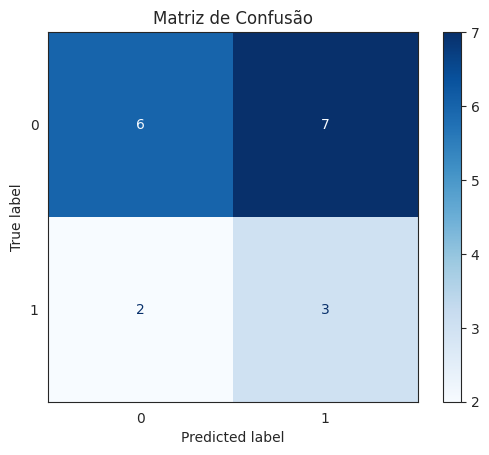

In [32]:
# Criando o modelo de predição
rf_model = DecisionTreeClassifier(
    random_state = 42,
    class_weight = 'balanced',
    max_depth = 5
)

# Treinando o modelo com o FIT
rf_model.fit(X_train, y_train)

# Gerando as previsões com o modelo
y_pred = rf_model.predict(X_test)

# ===============================
# ======= Avaliando o resultado =
# ===============================

print('=' * 50 + 'Relátorio de Classificação' + '=' * 50)
print(f'\n{classification_report(y_test, y_pred)}')

# Visualizando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title('Matriz de Confusão')
plt.show()

==================================================Relátorio de Classificação==================================================

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.33      0.40      0.36         5

    accuracy                           0.61        18
   macro avg       0.54      0.55      0.54        18
weighted avg       0.63      0.61      0.62        18



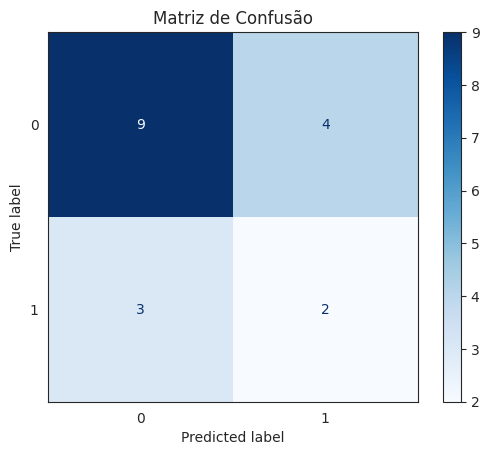

In [33]:
# Criando o modelo de predição
rf_model = RandomForestClassifier(
    random_state = 42,
    class_weight = 'balanced',
    n_estimators = 100,
    max_depth = 5
)

# Treinando o modelo com o FIT
rf_model.fit(X_train, y_train)

# Gerando as previsões com o modelo
y_pred = rf_model.predict(X_test)

# ===============================
# ======= Avaliando o resultado =
# ===============================

print('=' * 50 + 'Relátorio de Classificação' + '=' * 50)
print(f'\n{classification_report(y_test, y_pred)}')

# Visualizando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title('Matriz de Confusão')
plt.show()

=====Top 10 Variáveis Mais Importantes=====
                                      Feature  Importancia
3                               meses_de_casa     0.304847
1                          salario_contratual     0.084522
2                                       idade     0.075441
0                             qtd_dependentes     0.074540
24         perfil_comportamental_Não Mapeado.     0.052765
17       departamento_nome_api_RELACIONAMENTO     0.047558
30                                zona_cep_72     0.037333
29                                zona_cep_71     0.022253
16               departamento_nome_api_OUTROS     0.021862
10  escolaridade_Superior Incompleto/Cursando     0.020343

=
=
=
=
=
Top 10 Variáveis Mais Importantes
=
=
=
=
=
                            Feature  Importancia
7        estado_civil_União Estável     0.010315
20         perfil_comportamental_CE     0.009855
9    escolaridade_Superior Completo     0.008488
11          nivel_hierarquico_Baixo     0.007498
12     

/tmp/ipython-input-564634433.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


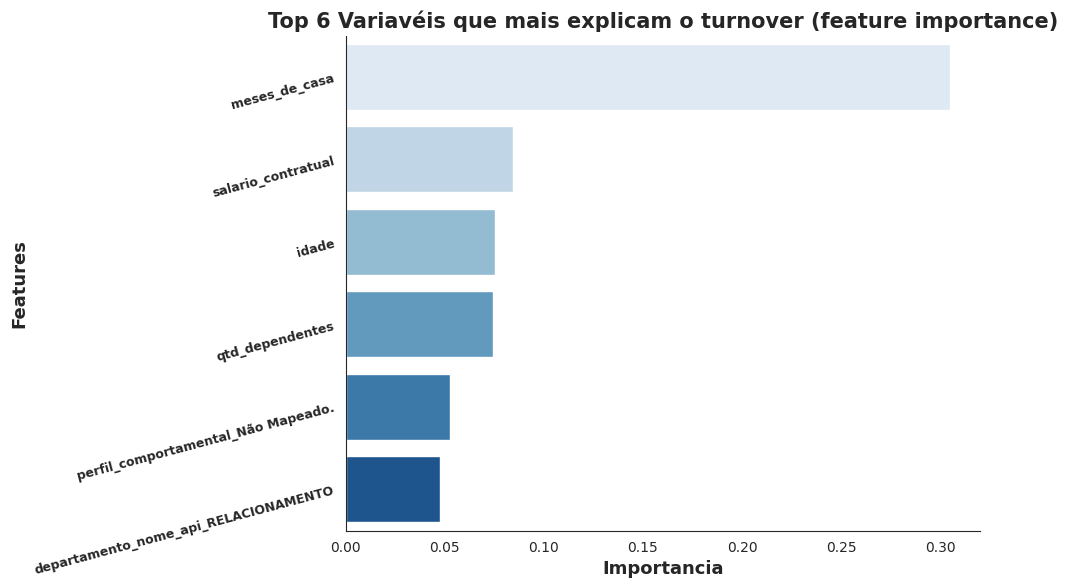

In [34]:
# Extraindo as importâncis de cada coluna pela random forest
importancias = rf_model.feature_importances_
colunas = X_train.columns

# Criando um dataset para organizar o ranking
df_importancias = pd.DataFrame({
    'Feature': colunas,
    'Importancia': importancias,
}).sort_values(
    by = 'Importancia',
    ascending = False
)

# Mostrando o top 10 e os piores
print("="* 5 + 'Top 10 Variáveis Mais Importantes' + '=' * 5)
print(df_importancias.head(10))

print("\n="* 5 + '\nTop 10 Variáveis Mais Importantes' + '\n=' * 5)
print(df_importancias.tail(10))

# Plotando um gráfico das 15 variáveis

fig, ax = plt.subplots(figsize = (10,6))
sns.set_style('white')
sns.barplot(
    data = df_importancias.head(6),
    x = 'Importancia',
    y = 'Feature',
    palette = 'Blues',
    ax = ax
)
plt.xlabel('Importancia', fontsize = 13,
           fontweight = 'bold')

plt.ylabel('Features', fontsize = 13,
           fontweight = 'bold')

plt.yticks(fontsize = 9,
           rotation = 15,
           fontweight = 'bold')
ax.spines[['top', 'right']].set_visible(False)

plt.title(
    'Top 6 Variavéis que mais explicam o turnover (feature importance)',
    fontsize = 15,
    fontweight = 'bold'
)

plt.tight_layout()

plt.savefig(
    'gini_importance.png',
    dpi = 900
)

plt.show()

=========================Relátorio de Classificação=========================

              precision    recall  f1-score   support

           0       0.82      0.69      0.75        13
           1       0.43      0.60      0.50         5

    accuracy                           0.67        18
   macro avg       0.62      0.65      0.62        18
weighted avg       0.71      0.67      0.68        18



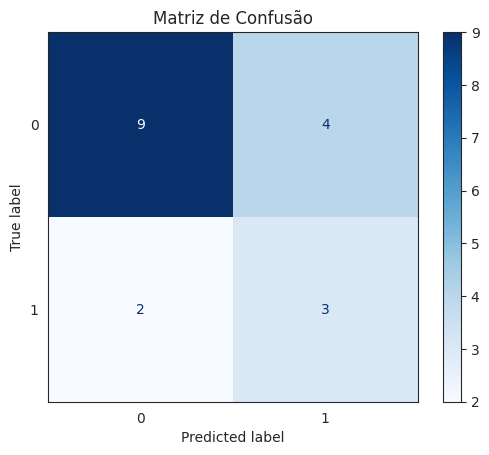

In [35]:
# VAmos começar a limpar as colunas sem importancia para o modelo
features_campeas = [
    'meses_de_casa',
    'salario_contratual',
    'idade',
    'qtd_dependentes',
    'perfil_comportamental_Não Mapeado.',
    'departamento_nome_api_RELACIONAMENTO',
]

X_enxuto = X[features_campeas]

# Refazendo a divisao entre treino e teste com a nova base limpa
X_train_magro, X_test_magro, y_train, y_test = train_test_split(
    X_enxuto, y, test_size = 0.20, stratify = y, random_state = 42
)

# Criando a RandomFlorest novamente com class_weight para focar em quem sai
rf_campeao = RandomForestClassifier(
    random_state = 42,
    class_weight = 'balanced',
    n_estimators = 100,
    max_depth = 5
)

# Treinando o novo modelo focado
rf_campeao.fit(X_train_magro, y_train)

# Fazendo o novo predict
y_pred_campeao = rf_campeao.predict(X_test_magro)

# ===============================
# ==== Avaliando o resultado ====
# ===============================

print('=' * 25 + 'Relátorio de Classificação' + '=' * 25)
print(f'\n{classification_report(y_test, y_pred_campeao)}')

# Visualizando a matriz de confusão
cm = confusion_matrix(y_test, y_pred_campeao)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title('Matriz de Confusão')
plt.show()

==================================================Relátorio de Classificação==================================================

              precision    recall  f1-score   support

           0       0.75      0.46      0.57        13
           1       0.30      0.60      0.40         5

    accuracy                           0.50        18
   macro avg       0.53      0.53      0.49        18
weighted avg       0.62      0.50      0.52        18



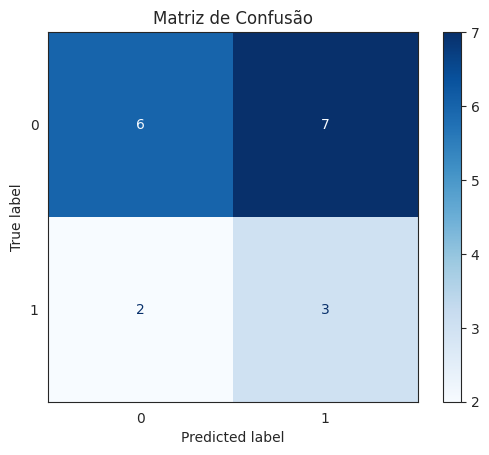

In [36]:
# VAmos começar a limpar as colunas sem importancia para o modelo
features_campeas = [
    'meses_de_casa',
    'salario_contratual',
    'idade',
    'qtd_dependentes',
    'perfil_comportamental_Não Mapeado.',
    'departamento_nome_api_RELACIONAMENTO',
]

X_enxuto = X[features_campeas]

# Refazendo a divisao entre treino e teste com a nova base limpa
X_train_magro, X_test_magro, y_train, y_test = train_test_split(
    X_enxuto, y, test_size = 0.2, stratify = y, random_state = 42
)

# Criando a RandomFlorest novamente com class_weight para focar em quem sai
rf_campeao = DecisionTreeClassifier(
    random_state = 42,
    class_weight = 'balanced',
    max_depth = 5
)

# Treinando o novo modelo focado
rf_campeao.fit(X_train_magro, y_train)

# Fazendo o novo predict
y_pred_campeao = rf_campeao.predict(X_test_magro)

# ===============================
# ==== Avaliando o resultado ====
# ===============================

print('=' * 50 + 'Relátorio de Classificação' + '=' * 50)
print(f'\n{classification_report(y_test, y_pred_campeao)}')

# Visualizando a matriz de confusão
cm = confusion_matrix(y_test, y_pred_campeao)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title('Matriz de Confusão')
plt.show()

Iniciando o laboratório de clonagem de dados...

--- ANTES DO SMOTE (Treino) ---
target_pediu_demissao
0    49
1    22
Name: count, dtype: int64

--- DEPOIS DO SMOTE (Treino Balanceado) ---
target_pediu_demissao
0    49
1    49
Name: count, dtype: int64

NOVO RELATÓRIO DE CLASSIFICAÇÃO (COM SMOTE)
              precision    recall  f1-score   support

           0       0.88      0.54      0.67        13
           1       0.40      0.80      0.53         5

    accuracy                           0.61        18
   macro avg       0.64      0.67      0.60        18
weighted avg       0.74      0.61      0.63        18


RELATÓRIO DA VALIDAÇÃO CRUZADA
[90.   90.   90.   60.   90.   90.   70.   70.   77.78 77.78]


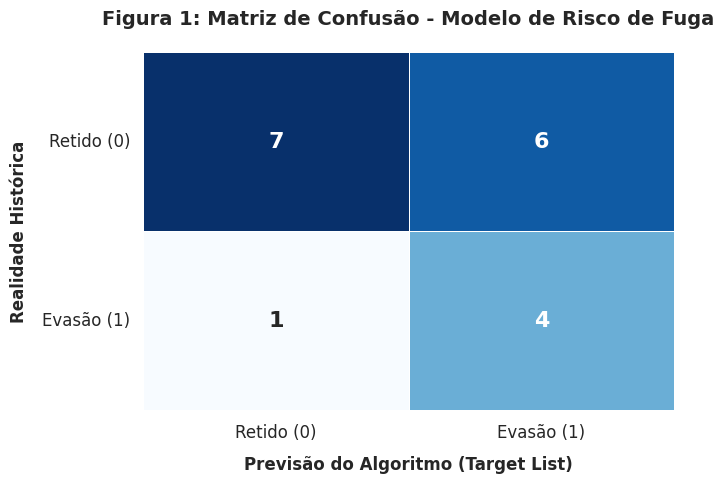

In [56]:
from sklearn.model_selection import cross_val_score
print("Iniciando o laboratório de clonagem de dados...\n")

# 1. Instanciando o "Fabricante de Clones"
smote = SMOTE(random_state=42)

# 2. Aplicando a mágica APENAS no Treino (A Regra de Ouro)
X_train_smote, y_train_smote = smote.fit_resample(X_train_magro, y_train)

# Auditando o crescimento da base
print("--- ANTES DO SMOTE (Treino) ---")
print(y_train.value_counts())
print("\n--- DEPOIS DO SMOTE (Treino Balanceado) ---")
print(y_train_smote.value_counts())

# 3. Treinando o Campeão com a nova base "anabolizada"
# Sem class_weight, pois o SMOTE já igualou o jogo
rf_smote = LogisticRegression(random_state=42, solver='liblinear', class_weight = 'balanced')
rf_smote.fit(X_test_magro, y_train_smote)

# 4. A Prova de Fogo (Prevendo na base de Teste original, que o modelo nunca viu)
y_pred_smote = rf_smote.predict(X_test_magro)

# 5. O Novo Boletim de Notas
print('\n' + '=' * 50 + '\nNOVO RELATÓRIO DE CLASSIFICAÇÃO (COM SMOTE)\n' + '=' * 50)
print(classification_report(y_test, y_pred_smote))

print('\n' + '=' * 50 + '\nRELATÓRIO DA VALIDAÇÃO CRUZADA\n' + '=' * 50)
# Corrected line: Pass the model (rf_smote) as the estimator
print(np.round(cross_val_score(rf_smote, X_train_smote, y_train_smote, cv = 10)* 100, 2))

# Plotando a nova Matriz de Confusão
sns.set_theme(style="white")
cm_smote = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(7, 5))

# Criando o Heatmap com a nossa cm_super (Matriz de Confusão do modelo top 6)
# annot=True coloca os números dentro, fmt='d' garante que sejam números inteiros
ax = sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues',
                 linewidths=.5, cbar=False, annot_kws={"size": 16, "weight": "bold"})

# Personalizando os eixos para o idioma de negócios
ax.set_xticklabels(['Retido (0)', 'Evasão (1)'], fontsize=12)
ax.set_yticklabels(['Retido (0)', 'Evasão (1)'], fontsize=12, rotation=0)

plt.title('Figura 1: Matriz de Confusão - Modelo de Risco de Fuga', fontsize=14, pad=20, weight='bold')
plt.xlabel('Previsão do Algoritmo (Target List)', fontsize=12, weight='bold', labelpad=10)
plt.ylabel('Realidade Histórica', fontsize=12, weight='bold', labelpad=10)

# Ajuste fino das bordas e exibição
plt.tight_layout()

plt.savefig(
    'Matriz_SMOTE.png',
    bbox_inches='tight',
    dpi=900
)
plt.show()

Processando previsões consolidadas...
[ 87.5   85.71  71.43 100.    71.43  71.43  71.43  85.71  57.14  85.71]


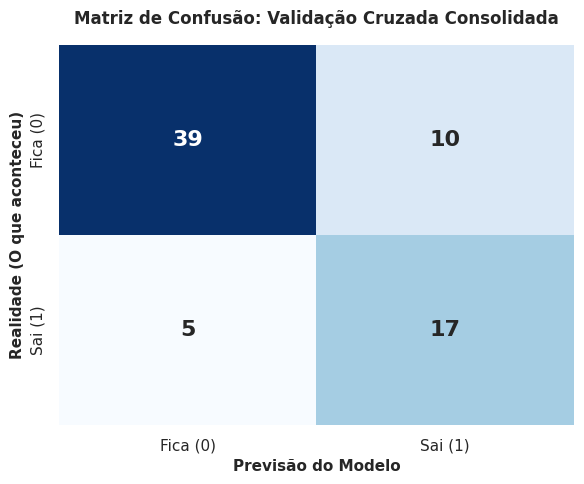


--- A PROVA DO RECALL (RELATÓRIO DE MÉTRICAS CONSOLIDADO) ---
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        49
           1       0.63      0.77      0.69        22

    accuracy                           0.79        71
   macro avg       0.76      0.78      0.77        71
weighted avg       0.81      0.79      0.79        71



In [65]:
from sklearn.model_selection import cross_val_predict
# Corrected: Import Pipeline from imblearn.pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Recriando o pipeline linear cravado que usamos no teste
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

# 2. Gerando previsões via Cross-Validation para a base INTEIRA de treino
# Atenção: Use suas variáveis originais (X_train, y_train) limpas, sem SMOTE prévio!
print("Processando previsões consolidadas...")
y_pred_cv = cross_val_predict(pipeline_lr, X_train, y_train, cv=10) # Removed y_train for the second time, as it is only necessary once

# 3. Gerando a Matriz de Confusão Global
cm_cv = confusion_matrix(y_train, y_pred_cv)
print(np.round(cross_val_score(pipeline_lr, X_train, y_train, cv = 10)* 100, 2))

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fica (0)', 'Sai (1)'],
            yticklabels=['Fica (0)', 'Sai (1)'],
            annot_kws={"size": 16, "weight": "bold"}, ax=ax)

ax.set_title('Matriz de Confusão: Validação Cruzada Consolidada', fontsize=12, fontweight='bold', pad=15)
ax.set_ylabel('Realidade (O que aconteceu)', fontsize=11, fontweight='bold')
ax.set_xlabel('Previsão do Modelo', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Imprimindo a Prova Real das Métricas
print("\n--- A PROVA DO RECALL (RELATÓRIO DE MÉTRICAS CONSOLIDADO) ---")
print(classification_report(y_train, y_pred_cv))

Processando previsões consolidadas...

[COPIE ESTES NÚMEROS PARA A SEÇÃO 4.6 DO WORD]:
[100.   100.    50.   100.    50.    50.    50.   100.   100.    66.67]
Média do Recall: 76.67%


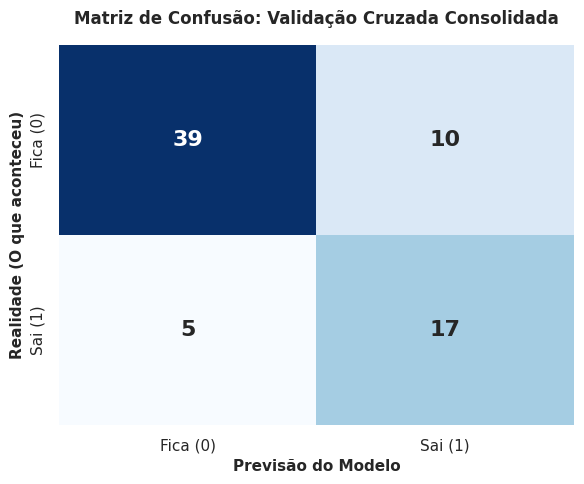


--- A PROVA DO RECALL (RELATÓRIO DE MÉTRICAS CONSOLIDADO) ---
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        49
           1       0.63      0.77      0.69        22

    accuracy                           0.79        71
   macro avg       0.76      0.78      0.77        71
weighted avg       0.81      0.79      0.79        71



In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict, cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Recriando o pipeline linear cravado
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

# 2. Gerando previsões via Cross-Validation para a base INTEIRA de treino
# Isso aqui gera a Matriz de Confusão
print("Processando previsões consolidadas...")
y_pred_cv = cross_val_predict(pipeline_lr, X_train, y_train, cv=10)

# 3. EXTRAINDO O ARRAY DE SCORES PARA O TEXTO (AQUI ESTAVA O DETALHE)
# Adicionamos scoring='recall' para ele medir a sensibilidade, não a acurácia
scores_recall = cross_val_score(pipeline_lr, X_train, y_train, cv=10, scoring='recall')

print("\n[COPIE ESTES NÚMEROS PARA A SEÇÃO 4.6 DO WORD]:")
print(np.round(scores_recall * 100, 2))
print(f"Média do Recall: {np.mean(scores_recall * 100):.2f}%")

# 4. Gerando a Matriz de Confusão Global Visual
cm_cv = confusion_matrix(y_train, y_pred_cv)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fica (0)', 'Sai (1)'],
            yticklabels=['Fica (0)', 'Sai (1)'],
            annot_kws={"size": 16, "weight": "bold"}, ax=ax)

ax.set_title('Matriz de Confusão: Validação Cruzada Consolidada', fontsize=12, fontweight='bold', pad=15)
ax.set_ylabel('Realidade (O que aconteceu)', fontsize=11, fontweight='bold')
ax.set_xlabel('Previsão do Modelo', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# 5. Imprimindo a Prova Real das Métricas
print("\n--- A PROVA DO RECALL (RELATÓRIO DE MÉTRICAS CONSOLIDADO) ---")
print(classification_report(y_train, y_pred_cv))

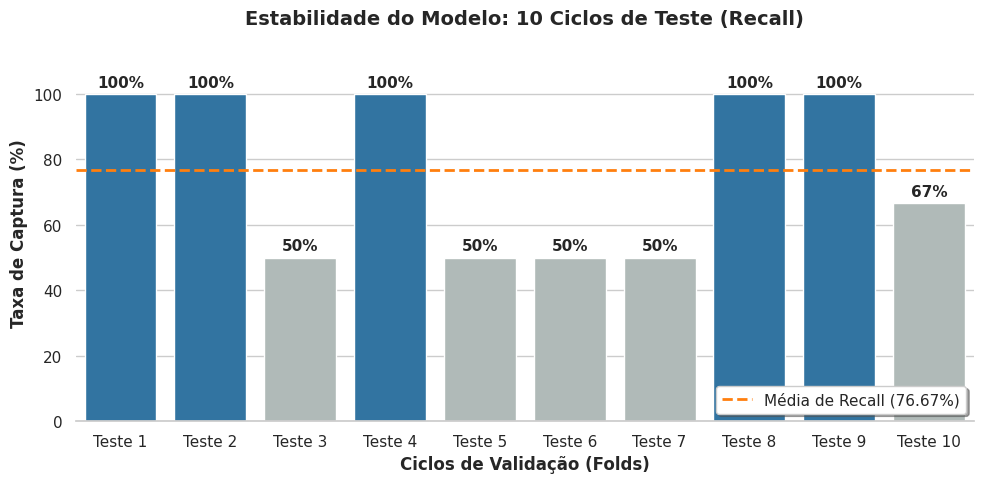

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Seus dados reais extraídos da saída anterior
scores_reais = [100.0, 100.0, 50.0, 100.0, 50.0, 50.0, 50.0, 100.0, 100.0, 66.67]
media_recall = 76.67

# 2. Configuração do Gráfico
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 5))

x_labels = [f'Teste {i+1}' for i in range(10)]

# Cores: Azul Forte para quem bateu a meta (>=70%), Azul Claro para os outros
cores = ['#1f77b4' if r >= 70 else '#aebcb9' for r in scores_reais]

bars = sns.barplot(x=x_labels, y=scores_reais, palette=cores, ax=ax)

# 3. Linha da Média
ax.axhline(media_recall, color='#ff7f0e', linestyle='--', linewidth=2, label=f'Média de Recall ({media_recall}%)')

# 4. Rótulos (Valores em cima das barras)
for bar, recall in zip(bars.patches, scores_reais):
    ax.annotate(f'{recall:.0f}%',
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold', xytext=(0, 3), textcoords='offset points')

# 5. Formatação Executiva
ax.set_ylim(0, 115)
ax.set_title('Estabilidade do Modelo: 10 Ciclos de Teste (Recall)', fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Taxa de Captura (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Ciclos de Validação (Folds)', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)

sns.despine(left=True)
plt.tight_layout()
plt.show()

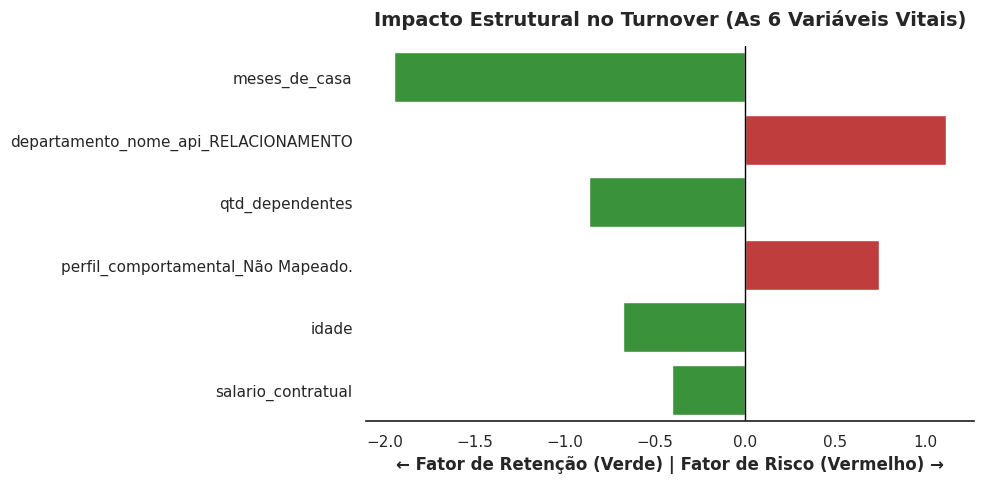

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Lista exata das variáveis que prometemos no texto (Section 3.1)
features_vitais = [
    'meses_de_casa',
    'salario_contratual',
    'idade',
    'qtd_dependentes',
    'departamento_nome_api_RELACIONAMENTO',
    'perfil_comportamental_Não Mapeado.'
    # Obs: Verifique se o nome da coluna do perfil está exato no seu pandas (com ou sem ponto final)
]

# 2. Extraindo coeficientes
pipeline_lr.fit(X_train, y_train)
coeficientes = pipeline_lr.named_steps['lr'].coef_[0]
nomes_features = X_train.columns
df_coef = pd.DataFrame({'Feature': nomes_features, 'Coeficiente': coeficientes})

# 3. FILTRAGEM ESTRATÉGICA (A Mágica acontece aqui)
# Filtramos apenas as linhas que contêm os nomes das nossas features vitais
df_filtrado = df_coef[df_coef['Feature'].isin(features_vitais)].copy()
df_filtrado['Abs_Coef'] = df_filtrado['Coeficiente'].abs()
df_filtrado = df_filtrado.sort_values(by='Abs_Coef', ascending=False)

# 4. Definição de Cores (Semântica de Negócios)
# Vermelho = Aumenta Risco (Positivo) | Verde = Aumenta Retenção (Negativo)
cores = ['#d62728' if x > 0 else '#2ca02c' for x in df_filtrado['Coeficiente']]

# 5. Plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(x='Coeficiente', y='Feature', data=df_filtrado, palette=cores, ax=ax)

# Linha Central
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

# Títulos
ax.set_title('Impacto Estrutural no Turnover (As 6 Variáveis Vitais)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('← Fator de Retenção (Verde) | Fator de Risco (Vermelho) →', fontsize=12, fontweight='bold')
ax.set_ylabel('')

# Ajuste visual para limpar o gráfico
sns.despine(left=True)
plt.tight_layout()
plt.show()

Calculando probabilidades consolidadas...


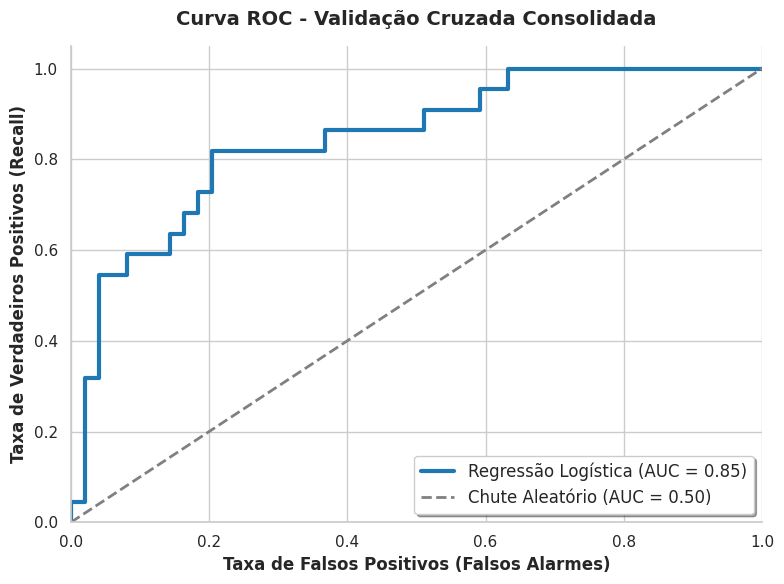

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

# 1. Extraindo as probabilidades contínuas (e não apenas 0 ou 1) via Cross-Validation
# Lembrete: pipeline_lr, X_train e y_train já devem estar carregados na sua sessão
print("Calculando probabilidades consolidadas...")
y_proba_cv = cross_val_predict(pipeline_lr, X_train, y_train, cv=10, method='predict_proba')[:, 1]

# 2. Calculando a taxa de acertos e falsos alarmes para a Curva
fpr, tpr, thresholds = roc_curve(y_train, y_proba_cv)
roc_auc = auc(fpr, tpr)

# 3. Plotando o Gráfico (Design Executivo)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

# Linha do nosso modelo (Azul Corporativo)
ax.plot(fpr, tpr, color='#1f77b4', lw=3, label=f'Regressão Logística (AUC = {roc_auc:.2f})')

# Linha do acaso (Tracejada)
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chute Aleatório (AUC = 0.50)')

# Formatação dos Eixos e Textos
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Taxa de Falsos Positivos (Falsos Alarmes)', fontsize=12, fontweight='bold')
ax.set_ylabel('Taxa de Verdadeiros Positivos (Recall)', fontsize=12, fontweight='bold')
ax.set_title('Curva ROC - Validação Cruzada Consolidada', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc="lower right", fontsize=12, frameon=True, shadow=True)

sns.despine()
plt.tight_layout()
plt.show()

In [54]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# 1. Configuração do Validador
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=42)

# 2. MODELO LR (Mantemos igual, pois foi muito bem)
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

# 3. MODELO RF (TURBINADO E SEM ALGEMAS)
# Tiramos o max_depth e aumentamos n_estimators para dar mais estabilidade
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=500,     # Mais árvores para reduzir a variância
        max_depth=None,       # Deixa a árvore crescer o quanto precisar
        min_samples_leaf=2    # Uma pequena trava para não overfitar demais
    ))
])

metricas = ['recall', 'roc_auc', 'precision', 'f1']

print('---------- ROUND FINAL: LR vs RF (Turbinado) ---------')

# Avaliando LR
resultados_lr = cross_validate(pipeline_lr, X_train, y_train, cv=cv, scoring=metricas)
recall_lr = resultados_lr['test_recall'].mean() * 100
auc_lr = resultados_lr['test_roc_auc'].mean() * 100
print(f'LOGISTIC REGRESSION -> Recall: {recall_lr:.2f}% | AUC: {auc_lr:.2f}%')

# Avaliando RF
resultados_rf = cross_validate(pipeline_rf, X_train, y_train, cv=cv, scoring=metricas)
recall_rf = resultados_rf['test_recall'].mean() * 100
auc_rf = resultados_rf['test_roc_auc'].mean() * 100
print(f'RANDOM FOREST       -> Recall: {recall_rf:.2f}% | AUC: {auc_rf:.2f}%')

print(f'\nDiferença Recall (RF - LR): {recall_rf - recall_lr:.2f} p.p.')

---------- ROUND FINAL: LR vs RF (Turbinado) ---------
LOGISTIC REGRESSION -> Recall: 76.63% | AUC: 85.83%
RANDOM FOREST       -> Recall: 65.87% | AUC: 86.45%

Diferença Recall (RF - LR): -10.77 p.p.


/tmp/ipython-input-3972485822.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[f"Teste {i+1}" for i in range(len(scores_kfold))],


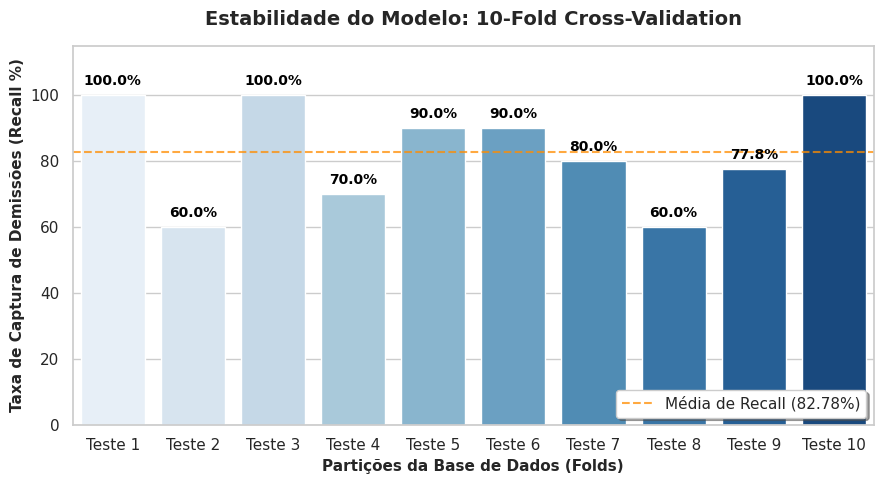

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Nossos resultados do K-Fold
scores_kfold = [100.0, 60.0, 100.0, 70.0, 90.0, 90.0, 80.0, 60.0, 77.78, 100.0]
media_kfold = np.mean(scores_kfold)

# Configurando o estilo executivo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(9, 5))

# Criando o gráfico de barras
ax = sns.barplot(x=[f"Teste {i+1}" for i in range(len(scores_kfold))],
                 y=scores_kfold,
                 palette="Blues")

# Adicionando a linha da Média
plt.axhline(media_kfold, color='darkorange', linestyle='--', linewidth=1.5,
            label=f'Média de Recall ({media_kfold:.2f}%)',
            alpha = 0.75)

# Colocando os rótulos de dados em cima de cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10, color='black', weight='bold', xytext=(0, 5),
                textcoords='offset points')

# Ajustes visuais
plt.ylim(0, 115) # Dando um respiro acima dos 100%
plt.title('Estabilidade do Modelo: 10-Fold Cross-Validation', fontsize=14, pad=15, weight='bold')
plt.ylabel('Taxa de Captura de Demissões (Recall %)', fontsize=11, weight='bold')
plt.xlabel('Partições da Base de Dados (Folds)', fontsize=11, weight='bold')
plt.legend(loc='lower right', frameon=True, shadow=True)

plt.tight_layout()
plt.show()

In [40]:
import pandas as pd

# 1. Extraindo as porcentagens de risco (A mágica do predict_proba)
# O [:, 1] pega exatamente a coluna que representa a chance de ser "1" (Demissão)
probabilidades = rf_smote.predict_proba(X_test_magro)[:, 1]

# 2. Criando o Relatório Executivo
df_risco = X_test_magro.copy()
df_risco['Probabilidade_Fuga (%)'] = (probabilidades * 100).round(2)
df_risco['Previsao_Robo'] = y_pred_smote  # O que o modelo cravou (0 ou 1)
df_risco['Gabarito_Real'] = y_test        # O que realmente aconteceu

# 3. Ordenando do maior risco para o menor (A Fila de Prioridade do RH)
df_relatorio_final = df_risco.sort_values(by='Probabilidade_Fuga (%)', ascending=False)

print("=" * 60)
print("🎯 TARGET LIST - TOP 10 COLABORADORES COM MAIOR RISCO DE FUGA")
print("=" * 60)
print(df_relatorio_final[['Probabilidade_Fuga (%)', 'Previsao_Robo', 'Gabarito_Real']].head(10))

🎯 TARGET LIST - TOP 10 COLABORADORES COM MAIOR RISCO DE FUGA
    Probabilidade_Fuga (%)  Previsao_Robo  Gabarito_Real
62                   89.48              1              1
5                    85.49              1              1
59                   82.21              1              0
47                   79.40              1              1
25                   74.67              1              0
53                   70.65              1              0
89                   60.31              1              0
38                   56.89              1              0
29                   55.51              1              0
88                   38.18              0              0


In [41]:
# ==========================================
# 🚀 AMBIENTE DE PRODUÇÃO (INFERÊNCIA REAL)
# ==========================================

# 1. Isolando apenas os funcionários ATIVOS (target == 0) a partir do dataset processado
df_ativos_ml = data[data['target_pediu_demissao'] == 0].copy()

# 2. Entregando para a IA apenas as colunas que ela aprendeu a ler (A Elite)
X_ativos = df_ativos_ml[features_campeas]

# 3. Rodando o Scanner de Risco (A mágica do predict_proba)
probabilidades_producao = rf_smote.predict_proba(X_ativos)[:, 1]

# 4. Montando o Relatório Executivo Oficial
df_relatorio_producao = pd.DataFrame({
    'colaborador_sk': df_clean.loc[df_ativos_ml.index, 'colaborador_sk'],
    # Você pode descomentar a linha abaixo se quiser adicionar o cargo
    # 'cargo': df_clean.loc[df_ativos_ml.index, 'cargo_nome_api'],
    'Risco_Fuga_Real (%)': (probabilidades_producao * 100).round(2)
})

# 5. Ordenando a Fila de Prioridade do RH (Do maior risco para o menor)
df_relatorio_producao = df_relatorio_producao.sort_values(by='Risco_Fuga_Real (%)', ascending=False)

print("=" * 70)
print("🚨 TARGET LIST PRODUÇÃO - TOP 10 COLABORADORES ATIVOS EM RISCO 🚨")
print("=" * 70)
print(df_relatorio_producao.head(10))

# Salvando em Excel para a Diretoria
# df_relatorio_producao.to_csv('target_list_ativos_rh.csv', index=False)

🚨 TARGET LIST PRODUÇÃO - TOP 10 COLABORADORES ATIVOS EM RISCO 🚨
    colaborador_sk  Risco_Fuga_Real (%)
59             114                82.21
25              56                74.67
53               9                70.65
21              89                66.84
60              95                65.35
89              51                60.31
38             107                56.89
29              64                55.51
2              125                49.54
28              24                48.82


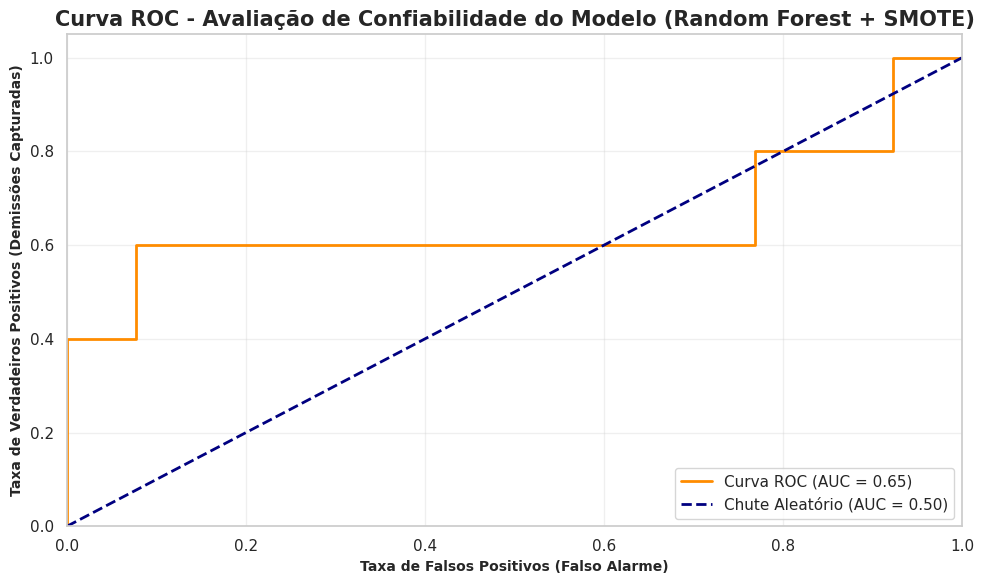

🎯 Score AUC Final: 0.646


In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Pegando as probabilidades do nosso modelo Campeão na Prova Cega
y_pred_proba = rf_smote.predict_proba(X_test_magro)[:, 1]

# 2. Calculando a Curva ROC e o Score AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# 3. Plotando o Gráfico Padrão Executivo
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('white')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chute Aleatório (AUC = 0.50)')

# Configurações visuais do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (Falso Alarme)', fontsize = 10, fontweight='bold')
plt.ylabel('Taxa de Verdadeiros Positivos (Demissões Capturadas)', fontsize = 10, fontweight='bold')
plt.title('Curva ROC - Avaliação de Confiabilidade do Modelo (Random Forest + SMOTE)', fontsize = 15, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(
    'curva_auc.png',
    dpi = 900
)
# Exibindo o Gráfico
plt.show()

print(f"🎯 Score AUC Final: {auc_score:.3f}")

In [43]:
# Separando quem saiu (1) de quem ficou (0)
df_saidas = df_clean[df_clean['target_pediu_demissao'] == 1]
df_retidos = df_clean[df_clean['target_pediu_demissao'] == 0]

# Calculando a média salarial
media_salario_saidas = df_saidas['salario_contratual'].mean()
media_salario_retidos = df_retidos['salario_contratual'].mean()

print(f"Média Salarial dos 5 que SAÍRAM: R$ {media_salario_saidas:.2f}")
print(f"Média Salarial dos que FICARAM: R$ {media_salario_retidos:.2f}")


Média Salarial dos 5 que SAÍRAM: R$ 4343.95
Média Salarial dos que FICARAM: R$ 5095.32


In [44]:
std_salario_saidas = df_saidas['salario_contratual'].std()
std_salario_retidos = df_retidos['salario_contratual'].std()

print(f"Média de quem SAIU: R$ {media_salario_saidas:.2f} | Desvio Padrão: R$ {std_salario_saidas:.2f}")
print(f"Média de quem FICOU: R$ {media_salario_retidos:.2f} | Desvio Padrão: R$ {std_salario_retidos:.2f}")

print(f"Menor salario de quem saiu: R$ {df_saidas['salario_contratual'].min():.2f}")
print(f"Maior salario de quem saiu: R$ {df_saidas['salario_contratual'].max():.2f}")


Média de quem SAIU: R$ 4343.95 | Desvio Padrão: R$ 3157.01
Média de quem FICOU: R$ 5095.32 | Desvio Padrão: R$ 2877.55
Menor salario de quem saiu: R$ 801.00
Maior salario de quem saiu: R$ 15748.00


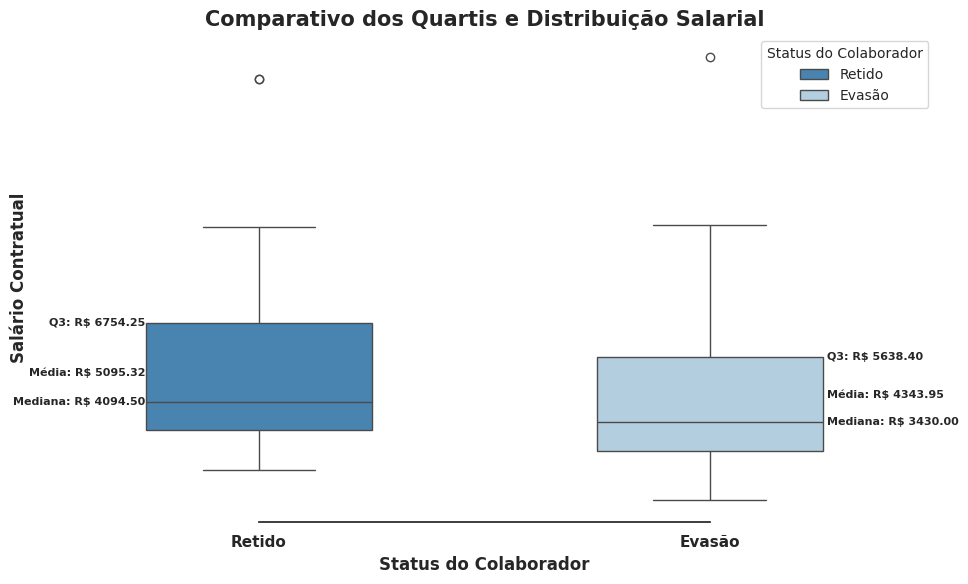

In [45]:
fig, ax = plt.subplots(
    figsize = (10, 6)
)
sns.set_style('white')
sns.boxplot(
    data = df_clean,
    x = 'target_pediu_demissao',
    y = 'salario_contratual',
    palette = 'Blues_r',
    hue = 'target_pediu_demissao',
    width = 0.5,
    ax = ax
)

plt.yticks([])
plt.ylabel('Salário Contratual', fontweight = 'bold')
plt.xlabel("Status do Colaborador", fontweight = 'bold')
estat_0 = df_clean[df_clean['target_pediu_demissao'] == 0]
mediana_estat_0 = estat_0['salario_contratual'].median()
med_estat_0 = estat_0['salario_contratual'].mean()
q3_0 = estat_0['salario_contratual'].quantile(0.75)


estat_1 = df_clean[df_clean['target_pediu_demissao'] == 1]
mediana_estat_1 = estat_1['salario_contratual'].median()
med_estat_1 = estat_1['salario_contratual'].mean()
q3_1 = estat_1['salario_contratual'].quantile(0.75)

# Set ticks explicitly to avoid UserWarning
ax.set_xticks([0, 1])
ax.set_xticklabels(
    ['Retido', 'Evasão'],
    fontweight = 'bold'
)

handles = ax.get_legend_handles_labels()
ax.legend(
    handles[0],
    ['Retido', 'Evasão'],
    title = 'Status do Colaborador',
    title_fontsize = 10,
    loc = 'upper right',
    fontsize = 10,
    frameon = True
)
ax.text(
    x = -0.545, y  = mediana_estat_0,
    s = f'Mediana: R$ {mediana_estat_0:.2f}', va = 'center',
    fontsize = 8, fontweight = 'bold'
)
ax.text(
    x = -0.465, y = q3_0,
    s = f"Q3: R$ {q3_0:.2f}", va = 'center',
    fontsize = 8, fontweight = 'bold'
)

ax.text(
    x = -0.51, y = med_estat_0,
    s = f"Média: R$ {med_estat_0:.2f}", va = 'center',
    fontsize = 8, fontweight = 'bold'
)

ax.text(
    x = 1.26, y  = mediana_estat_1,
    s = f'Mediana: R$ {mediana_estat_1:.2f}', va = 'center',
    fontsize = 8, fontweight = 'bold'
)
ax.text(
    x = 1.26, y = q3_1,
    s = f"Q3: R$ {q3_1:.2f}", va = 'center',
    fontsize = 8, fontweight = 'bold'
)

ax.text(
    x = 1.26, y = med_estat_1,
    s = f"Média: R$ {med_estat_1:.2f}", va = 'center',
    fontsize = 8, fontweight = 'bold'
)
plt.title(
    'Comparativo dos Quartis e Distribuição Salarial',
    fontweight = 'bold',
    fontsize = 15
)
sns.despine(trim=True)
plt.tight_layout()
ax.spines[['top', 'right', 'left']].set_visible(False)
plt.show()

In [46]:
desc_idade_saidas = df_saidas['idade'].describe()
desc_idade_retidos = df_retidos['idade'].describe()

desc_combined = pd.concat([
    desc_idade_saidas, desc_idade_retidos
], axis = 1, keys = ['Saídas', 'Retidos']).T

desc_combined

,count,mean,std,min,25%,50%,75%,max
Saídas,27.0,32.000000,7.358930,18.0,26.5,33.0,38.5,43.0
Retidos,62.0,34.032258,6.944671,21.0,29.0,33.0,38.0,51.0


In [47]:
df_retidos['idade'].describe()

,idade
count,62.000000
mean,34.032258
std,6.944671
min,21.000000
25%,29.000000
50%,33.000000
75%,38.000000
max,51.000000


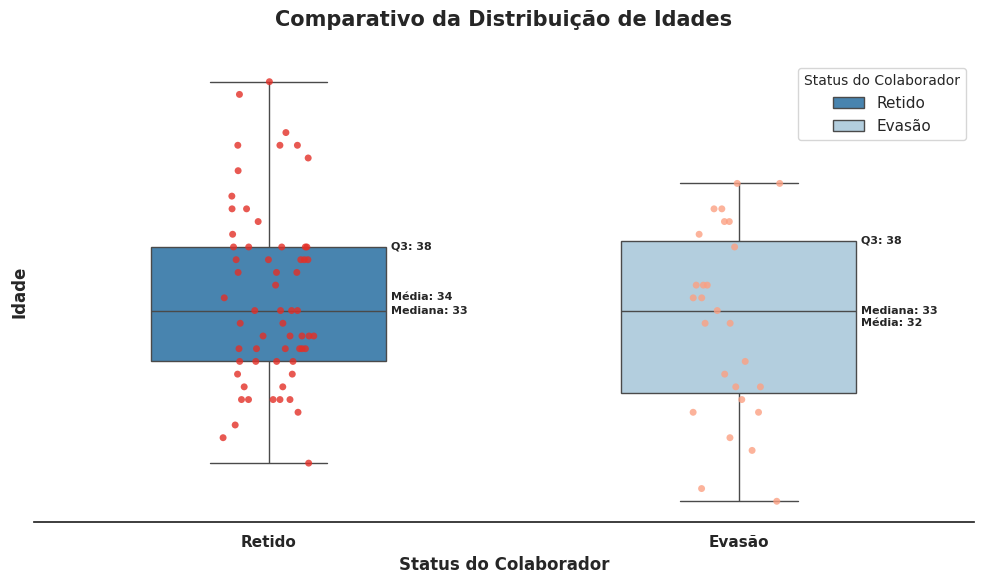

In [48]:
fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(
    data = df_clean,
    x = 'target_pediu_demissao',
    y = 'idade',
    palette = 'Blues_r',
    hue = 'target_pediu_demissao',
    width = 0.5,
    ax = ax
)

sns.stripplot(
    data = df_clean,
    x = 'target_pediu_demissao',
    y = 'idade',
    palette = 'Reds_r',
    hue = 'target_pediu_demissao',
    ax = ax,
    legend = False,
    alpha = 0.8
)

ax.spines[['top', 'right', 'left']].set_visible(False)
ax.set_xticks([0, 1])
ax.set_xticklabels(
    ['Retido', 'Evasão'],
    fontweight = 'bold'
)
ax.set_xlabel('Status do Colaborador', fontweight = 'bold')
plt.yticks([])
plt.ylabel('Idade', fontweight = 'bold')
handles = ax.get_legend_handles_labels()
ax.legend(
    handles[0],
    ['Retido', 'Evasão'],
    title = 'Status do Colaborador',
    title_fontsize = 10,
    loc = 'upper right'
    )
plt.title(
    'Comparativo da Distribuição de Idades',
    fontweight = 'bold',
    fontsize = 15,
    pad = 25
)
# Estats saídas
media_idade_saidas = df_saidas['idade'].mean()
mediana_idade_saidas = df_saidas['idade'].median()
q3_idade_saidas = df_saidas['idade'].quantile(0.75)

# Estats retidos]
media_idade_retidos = df_retidos['idade'].mean()
mediana_idade_retidos = df_retidos['idade'].median()
q3_idade_retidos = df_retidos['idade'].quantile(0.75)

ax.text(
    x = 1.26, y  = media_idade_saidas,
    s = f'Média: {media_idade_saidas:.0f}', va = 'center',
    fontsize = 8, fontweight = 'bold'
)

ax.text(
    x = 1.26, y = mediana_idade_saidas,
    s = f'Mediana: {mediana_idade_saidas:.0f}', va = 'center',
    fontsize =8 , fontweight = 'bold'
)

ax.text(
    x = 1.26, y = q3_idade_saidas,
    s = f"Q3: {q3_idade_saidas:.0f}", va = 'center',
    fontsize = 8 , fontweight = 'bold'
)

ax.text(
    x = 0.26, y  = media_idade_retidos,
    s = f'Média: {media_idade_retidos:.0f}', va = 'center',
    fontsize = 8, fontweight = 'bold'
)


ax.text(
    x = 0.26, y  = mediana_idade_retidos,
    s = f'Mediana: {mediana_idade_retidos:.0f}', va = 'center',
    fontsize = 8, fontweight = 'bold'
)

ax.text(
    x = 0.26, y  = q3_idade_retidos,
    s = f'Q3: {q3_idade_retidos:.0f}', va = 'center',
    fontsize = 8, fontweight = 'bold'
)


plt.tight_layout()
plt.show()